In [1]:
import os, sys
import numpy as np
import pickle
import uproot
import glob
import pandas as pd
from tqdm import tqdm
import json
import ROOT as rt
import fnmatch

## user define
sys.path.append('.')
sys.path.append('./Utils')
from Plotter import HistStack

from beeps import *

Welcome to JupyROOT 6.26/08


# Set config

In [2]:
# ERA="ee17"
# ERA="ee16pre"
# # ERA="mm18"
# ERA="em18"
# # DATE = '20230129_17_eleffmva'
# DATE = '20230301_18'
# # DATE = '20230130_18_dyhighworctight'
# # INPUTDIR = "/eos/user/h/hkwon/Run2/20230130_18_dyhighworctight/mm/"
# INPUTDIR = "/eos/user/h/hkwon/Run2/20230301_18/em/"
import sys
ERA = sys.argv[1]
DATE = sys.argv[2]
INPUTDIR = sys.argv[3]

DUMP_PKL = False
DRAW_SR = True
RUN_SIDEBAND_MET = False
RUN_SIDEBAND_MASS = False
RUN_SIDEBAND_PT = False
DUMP_SIDEBAND_MET_PKL = False
DUMP_SIDEBAND_MASS_PKL = False
DUMP_SIDEBAND_PT_PKL = False
RUN_BTAG = True
EXPORT_VARIABLE = False

# # for dev
# ERA = "ee16post"
# DATE = "20230526deepCSV_16post"
# INPUTDIR = "/eos/user/h/hkwon/Run2/"+DATE+"/ee/"


# Get input

In [3]:
lumi_all={
    "ee16pre":19520,
    "ee16post":16810,
    "ee17":41480,
    "ee18":59830,
    "mm16pre":19520,
    "mm16post":16810,
    "mm17":41480,
    "mm18":59830,    
#     "mm18":14000,    
    "em16pre":19520,
    "em16post":16810,
    "em17":41480,
    "em18":59830     
}

data_evts = {
    "ee16pre":652566543,
    "ee16post":287977113,
    "ee17":460041183,
    "ee18":1326465857,
    "mm16pre":458655573,
    "mm16post":327037312,
    "mm17":739073837,
#     "mm18":944842550,  #949352777 
    "mm18":949352777,  #949352777 
    "em16pre":1111222116,
    "em16post":615014425,
    "em17":1199115020,
#     "em18":2271308407   #2281001366  
    "em18":2281001366   #2281001366  
}

lumi=lumi_all[ERA]
print(ERA, lumi)

channel = ERA.replace("16pre", "")
channel = channel.replace("16post", "")
channel = channel.replace("17", "")
channel = channel.replace("18", "")

def get_df(root_file_name, unneccesary_columns):
    f = uproot.open(root_file_name)
    df = uproot.open(root_file_name)["Events_"+channel].arrays(library="pd")
    df_met_u = uproot.open(root_file_name)["Events_"+channel+"_met_u"].arrays(library="pd")
    df_met_d = uproot.open(root_file_name)["Events_"+channel+"_met_d"].arrays(library="pd")    
    df_met_ue_u = uproot.open(root_file_name)["Events_"+channel+"_met_ue_u"].arrays(library="pd")
    df_met_ue_d = uproot.open(root_file_name)["Events_"+channel+"_met_ue_d"].arrays(library="pd") 
    #     df_scale_u = uproot.open(root_file_name)["Events_"+channel+"_scale_u"].arrays(library="pd")
#     df_scale_d = uproot.open(root_file_name)["Events_"+channel+"_scale_d"].arrays(library="pd")
    info = uproot.open(root_file_name)["Info_"+channel].arrays(library="pd")
#     return sum(info["sumweight"]), df.drop(unneccesary_columns, axis=1), df_met_u.drop(unneccesary_columns, axis=1), df_met_d.drop(unneccesary_columns, axis=1), df_scale_u.drop(unneccesary_columns, axis=1), df_scale_d.drop(unneccesary_columns, axis=1)
    return sum(info["sumweight"]), df.drop(unneccesary_columns, axis=1), df_met_u.drop(unneccesary_columns, axis=1), df_met_d.drop(unneccesary_columns, axis=1), df_met_ue_u.drop(unneccesary_columns, axis=1), df_met_ue_d.drop(unneccesary_columns, axis=1)

unneccesary_columns = []
dic_input = {
    "ee16pre": "/eos/user/h/hkwon/Run2/"+DATE+"_16pre/ee/",
    "mm16pre": "/eos/user/h/hkwon/Run2/"+DATE+"_16pre/mm/",
    "em16pre": "/eos/user/h/hkwon/Run2/"+DATE+"_16pre/em/",
    "ee16post": "/eos/user/h/hkwon/Run2/"+DATE+"_16post/ee/",
    "mm16post": "/eos/user/h/hkwon/Run2/"+DATE+"_16post/mm/",
    "em16post": "/eos/user/h/hkwon/Run2/"+DATE+"_16post/em/",
    "ee17": "/eos/user/h/hkwon/Run2/"+DATE+"_17/ee/",
    "mm17": "/eos/user/h/hkwon/Run2/"+DATE+"_17/mm/",
    "em17": "/eos/user/h/hkwon/Run2/"+DATE+"_17/em/",
    "ee18": "/eos/user/h/hkwon/Run2/"+DATE+"_18/ee/",
    "mm18": "/eos/user/h/hkwon/Run2/"+DATE+"_18/mm/",    
    "em18": "/eos/user/h/hkwon/Run2/"+DATE+"_18/em/"        
#     "em18": "/eos/user/h/hkwon/Run2/20221120_18/em/"        
}
# input_dir = dic_input[ERA]
input_dir = INPUTDIR
f = []
for (dirpath, dirnames, filenames) in os.walk(input_dir):
    f.extend(filenames)
    break

dic_tup={}
for file in tqdm(f):
    # file naming: flatNtuple_Preselect_WZ1.root, flatNtuple_Preselect_Zp-3700_CH-1345.root
    if not "flatNtuple" in file:
        continue
#     if channel=="mm" and (fnmatch.fnmatch(file, '*E*Run*') or fnmatch.fnmatch(file, '*M*RunB*') or fnmatch.fnmatch(file, '*M*RunC*') or fnmatch.fnmatch(file, '*M*RunD*')): #temp
    if channel=="mm" and fnmatch.fnmatch(file, '*E*Run*'): #temp
        continue
    if channel=="ee" and fnmatch.fnmatch(file, '*M*Run*'):
        continue
#     if channel=="em" and fnmatch.fnmatch(file, '*E*Run*'):
#         continue  
    if "TT" in file and not "hadd" in file:
        continue
    if "DY" in file and not "hadd" in file and not "To" in file:
        continue  
    if "TW" in file and not "hadd" in file:
        continue         
    if "WW" in file and not "hadd" in file:
        continue  
    if "WZ" in file and not "hadd" in file:
        continue      
    if "ZZ" in file and not "hadd" in file:
        continue      
    if "Htt" in file and not "hadd" in file:
        continue  
        
    if "Zp" in file:
        sample=file.split('_')[2]+"_"+file.split('_')[3]
    else:
        print(file)
        sample=file.split('_')[2]
    sample=sample.rstrip('.root')
    try:
        print(sample)
        dic_tup[sample]=get_df(input_dir+file, unneccesary_columns)   
    except:
        print(sample)
        beep()        
        if "Run" in sample: # check file corrupt
            raise    
# dic_tup

ee16post 16810


  0%|          | 0/162 [00:00<?, ?it/s]

flatNtuple_Preselect_DY1000To15000.root
DY1000To15000


  2%|▏         | 3/162 [00:00<00:51,  3.08it/s]

flatNtuple_Preselect_DY1500To20000.root
DY1500To20000


  2%|▏         | 4/162 [00:01<01:21,  1.94it/s]

flatNtuple_Preselect_DY2000To30000.root
DY2000To30000


  4%|▎         | 6/162 [00:02<01:16,  2.03it/s]

flatNtuple_Preselect_DY500To7000.root
DY500To7000


  6%|▌         | 9/162 [00:03<01:00,  2.53it/s]

flatNtuple_Preselect_DY500To7001.root
DY500To7001


  6%|▌         | 10/162 [00:04<01:15,  2.00it/s]

flatNtuple_Preselect_DY700To8000.root
DY700To8000


  7%|▋         | 11/162 [00:05<01:27,  1.72it/s]

flatNtuple_Preselect_DY800To10000.root
DY800To10000


  7%|▋         | 12/162 [00:06<01:37,  1.54it/s]

flatNtuple_Preselect_DY_hadd.root
DY


  8%|▊         | 13/162 [00:07<01:49,  1.36it/s]

flatNtuple_Preselect_E16RunFver20.root
E16RunFver20


  9%|▊         | 14/162 [00:08<01:56,  1.27it/s]

flatNtuple_Preselect_E16RunG0.root
E16RunG0


  9%|▉         | 15/162 [00:09<02:01,  1.21it/s]

flatNtuple_Preselect_E16RunG1.root
E16RunG1


 10%|▉         | 16/162 [00:10<02:02,  1.20it/s]

flatNtuple_Preselect_E16RunG2.root
E16RunG2


 10%|█         | 17/162 [00:10<02:03,  1.18it/s]

flatNtuple_Preselect_E16RunG3.root
E16RunG3


 11%|█         | 18/162 [00:11<02:02,  1.17it/s]

flatNtuple_Preselect_E16RunG4.root
E16RunG4


 12%|█▏        | 19/162 [00:12<02:02,  1.16it/s]

flatNtuple_Preselect_E16RunG5.root
E16RunG5


 12%|█▏        | 20/162 [00:13<02:02,  1.16it/s]

flatNtuple_Preselect_E16RunG6.root
E16RunG6


 13%|█▎        | 21/162 [00:14<02:02,  1.15it/s]

flatNtuple_Preselect_E16RunG7.root
E16RunG7


 14%|█▎        | 22/162 [00:15<02:01,  1.15it/s]

flatNtuple_Preselect_E16RunH0.root
E16RunH0


 14%|█▍        | 23/162 [00:16<02:01,  1.14it/s]

flatNtuple_Preselect_E16RunH1.root
E16RunH1


 15%|█▍        | 24/162 [00:17<02:00,  1.14it/s]

flatNtuple_Preselect_E16RunH2.root
E16RunH2


 15%|█▌        | 25/162 [00:17<01:59,  1.15it/s]

flatNtuple_Preselect_E16RunH3.root
E16RunH3


 16%|█▌        | 26/162 [00:18<01:58,  1.15it/s]

flatNtuple_Preselect_E16RunH4.root
E16RunH4


 17%|█▋        | 27/162 [00:19<01:57,  1.15it/s]

flatNtuple_Preselect_E16RunH5.root
E16RunH5


 17%|█▋        | 28/162 [00:20<01:56,  1.15it/s]

flatNtuple_Preselect_E16RunH6.root
E16RunH6


 18%|█▊        | 29/162 [00:21<01:56,  1.14it/s]

flatNtuple_Preselect_E16RunH7.root
E16RunH7


 19%|█▊        | 30/162 [00:22<01:55,  1.14it/s]

flatNtuple_Preselect_HWW_hadd.root
HWW


 20%|█▉        | 32/162 [00:23<01:27,  1.49it/s]

flatNtuple_Preselect_Htt_hadd.root
H


 23%|██▎       | 37/162 [00:24<00:44,  2.79it/s]

flatNtuple_Preselect_TTDown_hadd.root
TTDown


 38%|███▊      | 62/162 [00:25<00:11,  8.42it/s]

flatNtuple_Preselect_TTSemi_hadd.root
TTSemi


 48%|████▊     | 77/162 [00:26<00:08,  9.84it/s]

flatNtuple_Preselect_TTUp_hadd.root
TTUp


 51%|█████     | 83/162 [00:28<00:10,  7.65it/s]

flatNtuple_Preselect_TTZ_hadd.root
TTZ


 56%|█████▌    | 91/162 [00:29<00:09,  7.22it/s]

flatNtuple_Preselect_TT_hadd.root
TT


 57%|█████▋    | 92/162 [00:32<00:16,  4.17it/s]

flatNtuple_Preselect_TThdampDown_hadd.root
TThdampDown


 59%|█████▊    | 95/162 [00:33<00:18,  3.58it/s]

flatNtuple_Preselect_TThdampUp_hadd.root
TThdampUp


 61%|██████    | 99/162 [00:34<00:19,  3.30it/s]

flatNtuple_Preselect_WWW_hadd.root
WWW


 68%|██████▊   | 110/162 [00:36<00:10,  4.88it/s]

flatNtuple_Preselect_WWZ_hadd.root
WWZ


 69%|██████▉   | 112/162 [00:37<00:11,  4.23it/s]

flatNtuple_Preselect_WW_hadd.root
WW


 70%|██████▉   | 113/162 [00:37<00:14,  3.50it/s]

flatNtuple_Preselect_WZQQ_hadd.root
WZQQ


 75%|███████▌  | 122/162 [00:38<00:08,  4.97it/s]

flatNtuple_Preselect_WZ_hadd.root
WZ


 76%|███████▌  | 123/162 [00:40<00:10,  3.72it/s]

flatNtuple_Preselect_ZZ_hadd.root
ZZ


 78%|███████▊  | 126/162 [00:41<00:11,  3.01it/s]

Zp-1700_CH-345


 78%|███████▊  | 127/162 [00:42<00:13,  2.56it/s]

Zp-1700_CH-595


 79%|███████▉  | 128/162 [00:43<00:15,  2.18it/s]

Zp-1700_CH-845


 80%|███████▉  | 129/162 [00:44<00:17,  1.88it/s]

Zp-2100_CH-345


 80%|████████  | 130/162 [00:45<00:19,  1.65it/s]

Zp-2100_CH-595


 81%|████████  | 131/162 [00:46<00:21,  1.47it/s]

Zp-2100_CH-845


 81%|████████▏ | 132/162 [00:47<00:22,  1.35it/s]

Zp-2500_CH-345


 82%|████████▏ | 133/162 [00:48<00:22,  1.27it/s]

Zp-2500_CH-595


 83%|████████▎ | 134/162 [00:49<00:23,  1.20it/s]

Zp-2500_CH-845


 83%|████████▎ | 135/162 [00:50<00:23,  1.15it/s]

Zp-2900_CH-1095


 84%|████████▍ | 136/162 [00:51<00:23,  1.11it/s]

Zp-2900_CH-1345


 85%|████████▍ | 137/162 [00:52<00:23,  1.08it/s]

Zp-2900_CH-345


 85%|████████▌ | 138/162 [00:53<00:22,  1.08it/s]

Zp-2900_CH-595


 86%|████████▌ | 139/162 [00:54<00:21,  1.07it/s]

Zp-2900_CH-845


 86%|████████▋ | 140/162 [00:55<00:20,  1.06it/s]

Zp-3300_CH-1095


 87%|████████▋ | 141/162 [00:56<00:20,  1.05it/s]

Zp-3300_CH-1345


 88%|████████▊ | 142/162 [00:57<00:19,  1.02it/s]

Zp-3300_CH-1595


 88%|████████▊ | 143/162 [00:58<00:18,  1.01it/s]

Zp-3300_CH-345


 89%|████████▉ | 144/162 [00:59<00:17,  1.02it/s]

Zp-3300_CH-595


 90%|████████▉ | 145/162 [01:00<00:16,  1.03it/s]

Zp-3300_CH-845


 90%|█████████ | 146/162 [01:00<00:15,  1.03it/s]

Zp-3700_CH-1095


 91%|█████████ | 147/162 [01:01<00:14,  1.02it/s]

Zp-3700_CH-1345


 91%|█████████▏| 148/162 [01:02<00:13,  1.01it/s]

Zp-3700_CH-1595


 92%|█████████▏| 149/162 [01:03<00:12,  1.01it/s]

Zp-3700_CH-1845


 93%|█████████▎| 150/162 [01:05<00:12,  1.00s/it]

Zp-3700_CH-345


 93%|█████████▎| 151/162 [01:05<00:10,  1.01it/s]

Zp-3700_CH-595


 94%|█████████▍| 152/162 [01:07<00:10,  1.00s/it]

Zp-3700_CH-845


 94%|█████████▍| 153/162 [01:07<00:08,  1.00it/s]

Zp-4100_CH-1095


 95%|█████████▌| 154/162 [01:08<00:07,  1.00it/s]

Zp-4100_CH-1345


 96%|█████████▌| 155/162 [01:10<00:07,  1.01s/it]

Zp-4100_CH-1595


 96%|█████████▋| 156/162 [01:11<00:06,  1.01s/it]

Zp-4100_CH-1845


 97%|█████████▋| 157/162 [01:12<00:05,  1.01s/it]

Zp-4100_CH-345


 98%|█████████▊| 158/162 [01:13<00:03,  1.00it/s]

Zp-4100_CH-595


 98%|█████████▊| 159/162 [01:13<00:02,  1.01it/s]

Zp-4100_CH-845


 99%|█████████▉| 160/162 [01:14<00:01,  1.01it/s]

flatNtuple_Preselect_antitop_hadd.root
antitop


 99%|█████████▉| 161/162 [01:15<00:00,  1.02it/s]

flatNtuple_Preselect_top_hadd.root
top


100%|██████████| 162/162 [01:16<00:00,  2.11it/s]


In [4]:
dic_tup.keys()

dict_keys(['DY1000To15000', 'DY1500To20000', 'DY2000To30000', 'DY500To7000', 'DY500To7001', 'DY700To8000', 'DY800To10000', 'DY', 'E16RunFver20', 'E16RunG0', 'E16RunG1', 'E16RunG2', 'E16RunG3', 'E16RunG4', 'E16RunG5', 'E16RunG6', 'E16RunG7', 'E16RunH0', 'E16RunH1', 'E16RunH2', 'E16RunH3', 'E16RunH4', 'E16RunH5', 'E16RunH6', 'E16RunH7', 'HWW', 'H', 'TTDown', 'TTSemi', 'TTUp', 'TTZ', 'TT', 'TThdampDown', 'TThdampUp', 'WWW', 'WWZ', 'WW', 'WZQQ', 'WZ', 'ZZ', 'Zp-1700_CH-345', 'Zp-1700_CH-595', 'Zp-1700_CH-845', 'Zp-2100_CH-345', 'Zp-2100_CH-595', 'Zp-2100_CH-845', 'Zp-2500_CH-345', 'Zp-2500_CH-595', 'Zp-2500_CH-845', 'Zp-2900_CH-1095', 'Zp-2900_CH-1345', 'Zp-2900_CH-345', 'Zp-2900_CH-595', 'Zp-2900_CH-845', 'Zp-3300_CH-1095', 'Zp-3300_CH-1345', 'Zp-3300_CH-1595', 'Zp-3300_CH-345', 'Zp-3300_CH-595', 'Zp-3300_CH-845', 'Zp-3700_CH-1095', 'Zp-3700_CH-1345', 'Zp-3700_CH-1595', 'Zp-3700_CH-1845', 'Zp-3700_CH-345', 'Zp-3700_CH-595', 'Zp-3700_CH-845', 'Zp-4100_CH-1095', 'Zp-4100_CH-1345', 'Zp-4100_

In [5]:
beep_ok()

In [6]:
# for key in dic_tup:
#     print(key)

In [7]:
# get x-sec
dic_xsec={}
with open('config/CrossSection.json') as json_file:
    data = json.load(json_file)
    dic_xsec=data
print(dic_xsec)

{'Data': 1, 'DY': 6077.22, 'DY500To700': 0.2558, 'DY700To800': 0.04023, 'DY800To1000': 0.03406, 'DY1000To1500': 0.01828, 'DY1500To2000': 0.002367, 'DY2000To3000': 0.0005409, 'TT': 88.29, 'TTUp': 88.29, 'TTDown': 88.29, 'TThdampUp': 88.29, 'TThdampDown': 88.29, 'TTSemi': 365.34, 'TTZ': 0.2432, 'top': 34.91, 'antitop': 34.91, 'WW': 12.82, 'WZ': 5.23, 'WZQQ': 6.42, 'ZZ': 0.6008, 'WWW': 0.0072, 'WWZ': 0.1707, 'HWW': 0.31, 'H': 2.78, 'Zp-1700_CH-345': 0.03523, 'Zp-1700_CH-595': 0.03523, 'Zp-1700_CH-845': 0.03523, 'Zp-2100_CH-345': 0.01198, 'Zp-2100_CH-595': 0.01198, 'Zp-2100_CH-845': 0.01198, 'Zp-2500_CH-345': 0.004396, 'Zp-2500_CH-595': 0.004396, 'Zp-2500_CH-845': 0.004396, 'Zp-2500_CH-1095': 0.004396, 'Zp-2900_CH-345': 0.001768, 'Zp-2900_CH-595': 0.001768, 'Zp-2900_CH-845': 0.001768, 'Zp-2900_CH-1095': 0.001768, 'Zp-2900_CH-1345': 0.001768, 'Zp-3300_CH-345': 0.000729, 'Zp-3300_CH-595': 0.000729, 'Zp-3300_CH-845': 0.000729, 'Zp-3300_CH-1095': 0.000729, 'Zp-3300_CH-1345': 0.000729, 'Zp-3300

In [8]:
Data_concat, TT_concat, TTSemi_concat, TTZ_concat, DY_concat, top_concat, antitop_concat, WW_concat, WZ_concat, ZZ_concat = ([] for i in range(10))
Data_concat_met_u, TT_concat_met_u, TTSemi_concat_met_u, TTZ_concat_met_u, DY_concat_met_u, top_concat_met_u, antitop_concat_met_u, WW_concat_met_u, WZ_concat_met_u, ZZ_concat_met_u = ([] for i in range(10))
Data_concat_met_d, TT_concat_met_d, TTSemi_concat_met_d, TTZ_concat_met_d, DY_concat_met_d, top_concat_met_d, antitop_concat_met_d, WW_concat_met_d, WZ_concat_met_d, ZZ_concat_met_d = ([] for i in range(10))
Data_concat_scale_u, TT_concat_scale_u, TTSemi_concat_scale_u, TTZ_concat_scale_u, DY_concat_scale_u, top_concat_scale_u, antitop_concat_scale_u, WW_concat_scale_u, WZ_concat_scale_u, ZZ_concat_scale_u = ([] for i in range(10))
Data_concat_scale_d, TT_concat_scale_d, TTSemi_concat_scale_d, TTZ_concat_scale_d, DY_concat_scale_d, top_concat_scale_d, antitop_concat_scale_d, WW_concat_scale_d, WZ_concat_scale_d, ZZ_concat_scale_d = ([] for i in range(10))
TTUp_concat, TTDown_concat, TThdampUp_concat, TThdampDown_concat = ([] for i in range(4)) 
TTUp_concat_met_u, TTDown_concat_met_u, TThdampUp_concat_met_u, TThdampDown_concat_met_u = ([] for i in range(4)) 
TTUp_concat_met_d, TTDown_concat_met_d, TThdampUp_concat_met_d, TThdampDown_concat_met_d = ([] for i in range(4)) 
Data_concat_met_ue_u, Data_concat_met_ue_d = ([] for i in range(2))  

Data_nevts, TT_nevts, TTSemi_nevts, TTZ_nevts, DY_nevts, top_nevts, antitop_nevts, WW_nevts, WZ_nevts, ZZ_nevts = ([] for i in range(10))
TTUp_nevts, TTDown_nevts, TThdampUp_nevts, TThdampDown_nevts = ([] for i in range(4))

merged_dic_df={}
for key in dic_tup:
#     if fnmatch.fnmatch(key, 'DY?') or fnmatch.fnmatch(key, 'DY1?'):
#         print(key)
# #         print(dic_tup[key][0])
#         DY_concat.append(dic_tup[key][1])
#         DY_concat_met_u.append(dic_tup[key][2])
#         DY_concat_met_d.append(dic_tup[key][3])        
# #         DY_concat_scale_u.append(dic_tup[key][4])
# #         DY_concat_scale_d.append(dic_tup[key][5])
#         DY_nevts.append(dic_tup[key][0])        
#     if fnmatch.fnmatch(key, 'TT?') or fnmatch.fnmatch(key, 'TT1?'):
# #         print("TT", key)
# #         print(dic_tup[key][0])
#         TT_concat.append(dic_tup[key][1])
#         TT_concat_met_u.append(dic_tup[key][2])
#         TT_concat_met_d.append(dic_tup[key][3])
# #         TT_concat_scale_u.append(dic_tup[key][4])
# #         TT_concat_scale_d.append(dic_tup[key][5])
#         TT_nevts.append(dic_tup[key][0])
#     if fnmatch.fnmatch(key, 'TThdampUp?') or fnmatch.fnmatch(key, 'TThdampUp1?'):
# #         print(key)
# #         print(dic_tup[key][0])
#         TThdampUp_concat.append(dic_tup[key][1])
#         TThdampUp_concat_met_u.append(dic_tup[key][2])
#         TThdampUp_concat_met_d.append(dic_tup[key][3])
#         TThdampUp_nevts.append(dic_tup[key][0])
#     if fnmatch.fnmatch(key, 'TThdampDown?') or fnmatch.fnmatch(key, 'TThdampDown1?'):
# #         print(key)
# #         print(dic_tup[key][0])
#         TThdampDown_concat.append(dic_tup[key][1])
#         TThdampDown_concat_met_u.append(dic_tup[key][2])
#         TThdampDown_concat_met_d.append(dic_tup[key][3])
#         TThdampDown_nevts.append(dic_tup[key][0])
#     if fnmatch.fnmatch(key, 'TTUp?') or fnmatch.fnmatch(key, 'TTUp1?'):
# #         print(key)
# #         print(dic_tup[key][0])
#         TTUp_concat.append(dic_tup[key][1])
#         TTUp_concat_met_u.append(dic_tup[key][2])
#         TTUp_concat_met_d.append(dic_tup[key][3])
#         TTUp_nevts.append(dic_tup[key][0])
#     if fnmatch.fnmatch(key, 'TTDown?') or fnmatch.fnmatch(key, 'TTDown1?'):
# #         print(key)
# #         print(dic_tup[key][0])
#         TTDown_concat.append(dic_tup[key][1])
#         TTDown_concat_met_u.append(dic_tup[key][2])
#         TTDown_concat_met_d.append(dic_tup[key][3])
#         TTDown_nevts.append(dic_tup[key][0])
#     if fnmatch.fnmatch(key, 'TTSemi*'):
# #         print(key)
# #         print(dic_tup[key][0])
#         TTSemi_concat.append(dic_tup[key][1])
#         TTSemi_concat_met_u.append(dic_tup[key][2])
#         TTSemi_concat_met_d.append(dic_tup[key][3])
# #         TTSemi_concat_scale_u.append(dic_tup[key][4])
# #         TTSemi_concat_scale_d.append(dic_tup[key][5])
#         TTSemi_nevts.append(dic_tup[key][0])
#     if fnmatch.fnmatch(key, 'TTZ*'):
# #         print(key)
# #         print(dic_tup[key][0])
#         TTZ_concat.append(dic_tup[key][1])
#         TTZ_concat_met_u.append(dic_tup[key][2])
#         TTZ_concat_met_d.append(dic_tup[key][3])
# #         TTZ_concat_scale_u.append(dic_tup[key][4])
# #         TTZ_concat_scale_d.append(dic_tup[key][5])
#         TTZ_nevts.append(dic_tup[key][0])
#     if fnmatch.fnmatch(key, 'TW?'):
# #         print(key)
# #         print(dic_tup[key][0])
#         top_concat.append(dic_tup[key][1])
#         top_concat_met_u.append(dic_tup[key][2])
#         top_concat_met_d.append(dic_tup[key][3])
# #         top_concat_scale_u.append(dic_tup[key][4])
# #         top_concat_scale_d.append(dic_tup[key][5])
#         top_nevts.append(dic_tup[key][0])        
#     elif fnmatch.fnmatch(key, 'TWa?'):
# #         print(key)
# #         print(dic_tup[key][0])
#         antitop_concat.append(dic_tup[key][1])
#         antitop_concat_met_u.append(dic_tup[key][2])
#         antitop_concat_met_d.append(dic_tup[key][3])
# #         antitop_concat_scale_u.append(dic_tup[key][4])
# #         antitop_concat_scale_d.append(dic_tup[key][5])
#         antitop_nevts.append(dic_tup[key][0]) 
#     if fnmatch.fnmatch(key, 'WW*'):
#         WW_concat.append(dic_tup[key][1])
#         WW_concat_met_u.append(dic_tup[key][2])
#         WW_concat_met_d.append(dic_tup[key][3])
# #         WW_concat_scale_u.append(dic_tup[key][4])
# #         WW_concat_scale_d.append(dic_tup[key][5])
#         WW_nevts.append(dic_tup[key][0])        
#     if fnmatch.fnmatch(key, 'WZ*'):
#         WZ_concat.append(dic_tup[key][1])
#         WZ_concat_met_u.append(dic_tup[key][2])
#         WZ_concat_met_d.append(dic_tup[key][3])
# #         WZ_concat_scale_u.append(dic_tup[key][4])
# #         WZ_concat_scale_d.append(dic_tup[key][5])
#         WZ_nevts.append(dic_tup[key][0])
#     elif fnmatch.fnmatch(key, 'ZZ*'):
#         ZZ_concat.append(dic_tup[key][1])
#         ZZ_concat_met_u.append(dic_tup[key][2])
#         ZZ_concat_met_d.append(dic_tup[key][3])
# #         ZZ_concat_scale_u.append(dic_tup[key][4])
# #         ZZ_concat_scale_d.append(dic_tup[key][5])
#         ZZ_nevts.append(dic_tup[key][0])        
    if fnmatch.fnmatch(key, '*Run*'):
        Data_concat.append(dic_tup[key][1])
        Data_concat_met_u.append(dic_tup[key][2])
        Data_concat_met_d.append(dic_tup[key][3])
        Data_concat_met_ue_u.append(dic_tup[key][4])
        Data_concat_met_ue_d.append(dic_tup[key][5])
#         Data_concat_scale_u.append(dic_tup[key][4])
#         Data_concat_scale_d.append(dic_tup[key][5])
        Data_nevts.append(dic_tup[key][0]) 
#     if fnmatch.fnmatch(key, 'Zp*'): 
#         merged_dic_df[key]=dic_tup[key]
#     if fnmatch.fnmatch(key, 'DY*To*'): 
#         merged_dic_df[key]=dic_tup[key]
# #         print("high", key)
    else: 
        merged_dic_df[key]=dic_tup[key]

In [9]:
dic_tup

{'DY1000To15000': (112786,
       PuppiMET_pre     mass_pre  pt_lead_pre  pt_trail_pre       U_pre  \
  0      217.967697   131.948883   263.289825    210.796432  243.524628   
  1      198.286423   524.980591   352.905914    175.717972   24.889164   
  2      126.932098   926.721802   576.201111    233.989838  672.366150   
  3      110.695305   971.632629   256.213928    217.456955   71.449120   
  4      211.071411   366.828491   354.283539     85.068542   62.578873   
  ..            ...          ...          ...           ...         ...   
  701    121.228088   950.828003   391.141632    361.202637   90.944809   
  702    100.961861   385.771820   163.088318     97.877312  145.710892   
  703    107.450073  1056.649170   652.829651    221.563797  450.993011   
  704    127.141815  1040.506958   403.988495    355.778870   77.684326   
  705    176.029480   533.063965   281.817657    152.608810   65.188049   
  
          JZB_pre  dPhill_pre  dPhilMET_pre       MT_pre     MT2_pre  

In [10]:
# # free memory 
# dic_tup.clear()

In [11]:
totalinput = """
######################################################
####   Total input number of events (sumweight)   ####
######################################################
"""

print(totalinput)
# if TT_concat:
# #     merged_dic_df['TT']=sum(TT_nevts), pd.concat(TT_concat), pd.concat(TT_concat_met_u), pd.concat(TT_concat_met_d), pd.concat(TT_concat_scale_u), pd.concat(TT_concat_scale_d)
#     merged_dic_df['TT']=sum(TT_nevts), pd.concat(TT_concat), pd.concat(TT_concat_met_u), pd.concat(TT_concat_met_d)
#     tmp = "TT: "+str(sum(TT_nevts))
#     print(tmp)
#     totalinput+=tmp+"\n"
# if TThdampUp_concat:
# #     merged_dic_df['TT']=sum(TT_nevts), pd.concat(TT_concat), pd.concat(TT_concat_met_u), pd.concat(TT_concat_met_d), pd.concat(TT_concat_scale_u), pd.concat(TT_concat_scale_d)
#     merged_dic_df['TThdampUp']=sum(TThdampUp_nevts), pd.concat(TThdampUp_concat), pd.concat(TThdampUp_concat_met_u), pd.concat(TThdampUp_concat_met_d)
#     tmp = "TThdampUp: "+str(sum(TThdampUp_nevts))
#     print(tmp)
#     totalinput+=tmp+"\n"
# if TThdampDown_concat:
# #     merged_dic_df['TT']=sum(TT_nevts), pd.concat(TT_concat), pd.concat(TT_concat_met_u), pd.concat(TT_concat_met_d), pd.concat(TT_concat_scale_u), pd.concat(TT_concat_scale_d)
#     merged_dic_df['TThdampDown']=sum(TThdampDown_nevts), pd.concat(TThdampDown_concat), pd.concat(TThdampDown_concat_met_u), pd.concat(TThdampDown_concat_met_d)
#     tmp = "TThdampDown: "+str(sum(TThdampDown_nevts))
#     print(tmp)
#     totalinput+=tmp+"\n"    
# if TTUp_concat:
# #     merged_dic_df['TT']=sum(TT_nevts), pd.concat(TT_concat), pd.concat(TT_concat_met_u), pd.concat(TT_concat_met_d), pd.concat(TT_concat_scale_u), pd.concat(TT_concat_scale_d)
#     merged_dic_df['TTUp']=sum(TTUp_nevts), pd.concat(TTUp_concat), pd.concat(TTUp_concat_met_u), pd.concat(TTUp_concat_met_d)
#     tmp = "TTUp: "+str(sum(TTUp_nevts))
#     print(tmp)
#     totalinput+=tmp+"\n"
# if TTDown_concat:
# #     merged_dic_df['TT']=sum(TT_nevts), pd.concat(TT_concat), pd.concat(TT_concat_met_u), pd.concat(TT_concat_met_d), pd.concat(TT_concat_scale_u), pd.concat(TT_concat_scale_d)
#     merged_dic_df['TTDown']=sum(TTDown_nevts), pd.concat(TTDown_concat), pd.concat(TTDown_concat_met_u), pd.concat(TTDown_concat_met_d)
#     tmp = "TTDown: "+str(sum(TTDown_nevts))
#     print(tmp)
#     totalinput+=tmp+"\n" 
# if TTSemi_concat:
# #     merged_dic_df['TTSemi']=sum(TTSemi_nevts), pd.concat(TTSemi_concat), pd.concat(TTSemi_concat_met_u), pd.concat(TTSemi_concat_met_d), pd.concat(TTSemi_concat_scale_u), pd.concat(TTSemi_concat_scale_d)
#     merged_dic_df['TTSemi']=sum(TTSemi_nevts), pd.concat(TTSemi_concat), pd.concat(TTSemi_concat_met_u), pd.concat(TTSemi_concat_met_d)
#     tmp = "TTSemi: "+str(sum(TTSemi_nevts))
#     print(tmp)
#     totalinput+=tmp+"\n"    
# if TTZ_concat:
# #     merged_dic_df['TTZ']=sum(TTZ_nevts), pd.concat(TTZ_concat), pd.concat(TTZ_concat_met_u), pd.concat(TTZ_concat_met_d), pd.concat(TTZ_concat_scale_u), pd.concat(TTZ_concat_scale_d)
#     merged_dic_df['TTZ']=sum(TTZ_nevts), pd.concat(TTZ_concat), pd.concat(TTZ_concat_met_u), pd.concat(TTZ_concat_met_d)
#     tmp = "TTZ: "+str(sum(TTZ_nevts))
#     print(tmp)
#     totalinput+=tmp+"\n"
# if DY_concat:
# #     merged_dic_df['DY']=sum(DY_nevts), pd.concat(DY_concat), pd.concat(DY_concat_met_u), pd.concat(DY_concat_met_d), pd.concat(DY_concat_scale_u), pd.concat(DY_concat_scale_d)
#     merged_dic_df['DY']=sum(DY_nevts), pd.concat(DY_concat), pd.concat(DY_concat_met_u), pd.concat(DY_concat_met_d)
#     tmp = "DY: "+str(sum(DY_nevts))
#     print(tmp)
#     totalinput+=tmp+"\n"    
# if top_concat:
#     df=pd.concat(top_concat)
# #     merged_dic_df['top']=sum(top_nevts), pd.concat(top_concat), pd.concat(top_concat_met_u), pd.concat(top_concat_met_d), pd.concat(top_concat_scale_u), pd.concat(top_concat_scale_d)
#     merged_dic_df['top']=sum(top_nevts), pd.concat(top_concat), pd.concat(top_concat_met_u), pd.concat(top_concat_met_d)
#     tmp = "top: "+str(sum(top_nevts))
#     print(tmp)
#     totalinput+=tmp+"\n" 
# if antitop_concat:
#     df=pd.concat(antitop_concat)
# #     merged_dic_df['antitop']=sum(antitop_nevts), pd.concat(antitop_concat), pd.concat(antitop_concat_met_u), pd.concat(antitop_concat_met_d), pd.concat(antitop_concat_scale_u), pd.concat(antitop_concat_scale_d)
#     merged_dic_df['antitop']=sum(antitop_nevts), pd.concat(antitop_concat), pd.concat(antitop_concat_met_u), pd.concat(antitop_concat_met_d)
#     tmp = "antitop: "+str(sum(antitop_nevts))
#     print(tmp)
#     totalinput+=tmp+"\n" 
# if ZZ_concat:
#     df=pd.concat(ZZ_concat)
# #     merged_dic_df['ZZ']=sum(ZZ_nevts), pd.concat(ZZ_concat), pd.concat(ZZ_concat_met_u), pd.concat(ZZ_concat_met_d), pd.concat(ZZ_concat_scale_u), pd.concat(ZZ_concat_scale_d)
#     merged_dic_df['ZZ']=sum(ZZ_nevts), pd.concat(ZZ_concat), pd.concat(ZZ_concat_met_u), pd.concat(ZZ_concat_met_d)
#     tmp = "ZZ: "+str(sum(ZZ_nevts))
#     print(tmp)
#     totalinput+=tmp+"\n" 
# if WZ_concat:
#     df=pd.concat(WZ_concat)
# #     merged_dic_df['WZ']=sum(WZ_nevts), pd.concat(WZ_concat), pd.concat(WZ_concat_met_u), pd.concat(WZ_concat_met_d), pd.concat(WZ_concat_scale_u), pd.concat(WZ_concat_scale_d)
#     merged_dic_df['WZ']=sum(WZ_nevts), pd.concat(WZ_concat), pd.concat(WZ_concat_met_u), pd.concat(WZ_concat_met_d)
#     tmp = "WZ: "+str(sum(WZ_nevts))
#     print(tmp)
#     totalinput+=tmp+"\n" 
# if WW_concat:
#     df=pd.concat(WW_concat)
# #     merged_dic_df['WW']=sum(WW_nevts), pd.concat(WW_concat), pd.concat(WW_concat_met_u), pd.concat(WW_concat_met_d), pd.concat(WW_concat_scale_u), pd.concat(WW_concat_scale_d)
#     merged_dic_df['WW']=sum(WW_nevts), pd.concat(WW_concat), pd.concat(WW_concat_met_u), pd.concat(WW_concat_met_d)
#     tmp = "WW: "+str(sum(WW_nevts))
#     print(tmp)
#     totalinput+=tmp+"\n" 
if Data_concat:
#     merged_dic_df['Data']=sum(Data_nevts), pd.concat(Data_concat), pd.concat(Data_concat_met_u), pd.concat(Data_concat_met_d), pd.concat(Data_concat_scale_u), pd.concat(Data_concat_scale_d)
    merged_dic_df['Data']=sum(Data_nevts), pd.concat(Data_concat), pd.concat(Data_concat_met_u), pd.concat(Data_concat_met_d), pd.concat(Data_concat_met_ue_u), pd.concat(Data_concat_met_ue_d)
    tmp = "Data: "+str(sum(Data_nevts))
    print(tmp)
    totalinput+=tmp+"\n" 
# merged_dic_df["Zp-2500"]=dic_tup["Zp-2500"][0], dic_tup["Zp-2500"][1] 
hadded = ["TT", "TTSemi", "TTUp", "TTDown", "TThdampUp", "TThdampDown", "top", "antitop", "WW", "WZ", "WZQQ", "DY", "TTZ", "ZZ", "H", "HWW", "WWW", "WWZ"]
for p in hadded:
    print(p, ":", merged_dic_df[p][0])


######################################################
####   Total input number of events (sumweight)   ####
######################################################

Data: 287977113
TT : 43193956
TTSemi : 143553998
TTUp : 17919868
TTDown : 18157240
TThdampUp : 18704950
TThdampDown : 17802041
top : 2490860
antitop : 2553882
WW : 2888924
WZ : 6890010
WZQQ : 8434516
DY : 48332646
TTZ : 2962856
ZZ : 15894442
H : 9088
HWW : 2838799
WWW : 1618856
WWZ : 4168038


In [12]:
os.system("mkdir -p "+DATE+"/Presel/"+ERA)
with open(DATE+"/Presel/"+ERA+'/Nevents.txt', 'w') as f:
    f.write(totalinput)

In [13]:
print("expected:", data_evts[ERA], ", while: ", sum(Data_nevts))

# try:
#    if data_evts[ERA]!=sum(Data_nevts):
#        raise ValueError('Data events missing!')
# except (ValueError, IndexError):
#    beep()
#    print("expected:", data_evts[ERA], ", while: ", sum(Data_nevts)) 
#    raise

expected: 287977113 , while:  287977113


In [14]:
dic_tup['TT']

(43193956,
         PuppiMET_pre    mass_pre  pt_lead_pre  pt_trail_pre       U_pre  \
 0         113.691254  136.220993    93.047249     52.334850  161.555817   
 1         133.783554  346.943298   262.177307    144.535538  243.818039   
 2         121.577705  144.882446    94.627998     61.600407  112.712059   
 3         151.706284  117.363152   101.423187     30.454868  215.358810   
 4         171.415390  138.120270   135.892014     35.065346  270.323151   
 ...              ...         ...          ...           ...         ...   
 120421    147.979523  392.169952   218.767746    206.539993  233.536011   
 120422    102.174225  268.580475   331.172974     55.405506  378.596588   
 120423    140.167038  134.947586    88.209015     44.491493   99.963074   
 120424    115.736732  140.354950   136.615601     34.816730   26.261990   
 120425    134.502472  194.807465   101.772858     98.334679  168.464493   
 
            JZB_pre  dPhill_pre  dPhilMET_pre      MT_pre    MT2_pre  ...  

In [15]:
# # temp!!
for key in merged_dic_df:
    df = merged_dic_df[key][1]
    df_met_u = merged_dic_df[key][2]
    df_met_d = merged_dic_df[key][3]    
    df_met_ue_u = merged_dic_df[key][4]
    df_met_ue_d = merged_dic_df[key][5]
#     df_scale_u = merged_dic_df[key][4]
#     df_scale_d = merged_dic_df[key][5]
#     print(df[df.isin([np.inf, -np.inf]).any(1)])
    if df.isnull().values.any():
        print("Warning, nan in",key)
        i = df[df.isin([np.nan, np.inf, -np.inf]).any(1)].index
        print(i)
        df_new = df.drop(i)
        df_met_u_new = df_met_u.drop(i)
        df_met_d_new = df_met_d.drop(i)        
        df_met_ue_u_new = df_met_ue_u
        df_met_ue_d_new = df_met_ue_d
#         print(df_new.isnull().values.any())
        #workaround for tuple assignment
#         merged_dic_df[key] = merged_dic_df[key][0], df_new, df_met_u_new, df_met_d_new, df_scale_u, df_scale_d
        merged_dic_df[key] = merged_dic_df[key][0], df_new, df_met_u_new, df_met_d_new, df_met_ue_u_new, df_met_ue_d_new
        


In [16]:
# sys = ["puweight_pre", "l1prefiring_pre", 'effSF_pre', 'topSF_pre', 'genweight_pre', 'trigSF_pre']
sys = ["puweight_pre", "l1prefiring_pre", 'effSF_pre', 'topSF_pre', 'genweight_pre', 'trigSF_pre', 'btagSF_pre']
# sys = ["puweight_pre", "l1prefiring_pre", 'effSF_pre', 'topSF_pre', 'genweight_pre']
eventweights = """
####################################################
####       event weights (normalization)        ####
####################################################
"""

def get_dic_with_weight(merged_dic_df):
    dic_df={}
    dic_df_met_u={}
    dic_df_met_d={}
    dic_df_met_ue_u={}
    dic_df_met_ue_d={}
    dic_df_scale_u={}
    dic_df_scale_d={}
    for key, vs in merged_dic_df.items():
        print(key) 
        if vs[0]==0:
            print("missing: ", key, "!, continue without it")
            continue
        if "Data" in key:
            norm=1
        else:
            if fnmatch.fnmatch(key, '*DY*To*'):
                key = key[:len(key)-1]
            norm=lumi*dic_xsec[key]/vs[0]
        print(key, ":", norm)
        global eventweights
        eventweights+=key+":"+str(norm)+"\n"
#         print(eventweights)
        dic_df[key]=vs[1]
        dic_df_met_u[key] = vs[2]
        dic_df_met_d[key] = vs[3]
        dic_df_met_ue_u[key] = vs[4]
        dic_df_met_ue_d[key] = vs[5]
#         dic_df_scale_u[key] = vs[4]
#         dic_df_scale_d[key]=vs[5]
        dic_df[key]["weight"] = vs[1]["genweight_pre"]*norm
        dic_df_met_u[key]["weightmetUp"] = vs[1]["genweight_pre"]*norm
        dic_df_met_d[key]["weightmetDown"] = vs[1]["genweight_pre"]*norm
        dic_df_met_ue_u[key]["weightmetueUp"] = vs[4]["totweight"].copy(deep=True)*norm
        dic_df_met_ue_d[key]["weightmetueDown"] =vs[5]["totweight"].copy(deep=True)*norm
#         dic_df_scale_u[key]["weightscaleUp"] = vs[4]["totweight"].copy(deep=True)
#         dic_df_scale_d[key]["weightscaleDown"] =vs[5]["totweight"].copy(deep=True)
        dic_df[key]["wopu"] = vs[1]["genweight_pre"]*norm
        dic_df[key]["wol1"] = vs[1]["genweight_pre"]*norm
        dic_df[key]["woeff"] = vs[1]["genweight_pre"]*norm
        dic_df[key]["wotop"] = vs[1]["genweight_pre"]*norm       
        dic_df[key]["wobsf"] = vs[1]["genweight_pre"]*norm       
      
        for s in sys:
            if s=="genweight_pre":
                continue
            dic_df[key]["weight"] *= vs[1][s]
            dic_df[key]["weighthdampUp"] = dic_df[key]["weight"].copy(deep=True)
            dic_df[key]["weighthdampDown"] = dic_df[key]["weight"].copy(deep=True)
            dic_df[key]["weightPSUp"] = dic_df[key]["weight"].copy(deep=True)
            dic_df[key]["weightPSDown"] = dic_df[key]["weight"].copy(deep=True)
            dic_df_met_u[key]["weightmetUp"] *= vs[1][s]
            dic_df_met_d[key]["weightmetDown"] *= vs[1][s]            

            # n-1 correction
            if s!="puweight_pre":
                dic_df[key]["wopu"] *= vs[1][s]
            if s!="l1prefiring_pre":
                dic_df[key]["wol1"] *= vs[1][s]
            if s!="effSF_pre":
                dic_df[key]["woeff"] *= vs[1][s]
#             if s!="topSF_pre":
            if not "top" in s:
                dic_df[key]["wotop"] *= vs[1][s]
            if s!="btagSF_pre":
                dic_df[key]["wobsf"] *= vs[1][s]
        #btag    
#         dic_df[key]["btag2"] = dic_df[key]["weight"].copy(deep=True)*vs[1]['btagSF2_pre'] 
#         dic_df[key]["btagSF"] = dic_df[key]["weight"].copy(deep=True)*vs[1]['btagSF_pre']
            
        # up, down    
        for s1 in sys:
            #if "top" in s1 or "eff" in s1:
#             if "btag" in s1:
#                 continue
            s_u = s1.replace("_", "_u_")
            s_d = s1.replace("_", "_d_")
            if s1=="genweight_pre":
                dic_df[key]["weight"+s_u.replace('_u_pre', 'Up')] = dic_df[key]["weight"].copy(deep=True)*np.fabs(dic_df[key][s_u])
                dic_df[key]["weight"+s_d.replace('_d_pre', 'Down')] = dic_df[key]["weight"].copy(deep=True)*np.fabs(dic_df[key][s_d])
            else:
                dic_df[key]["weight"+s_u.replace('_u_pre', 'Up')] = dic_df[key]["weight"].copy(deep=True)/dic_df[key][s1]*dic_df[key][s_u]
                dic_df[key]["weight"+s_d.replace('_d_pre', 'Down')] = dic_df[key]["weight"].copy(deep=True)/dic_df[key][s1]*dic_df[key][s_d]             
#     return dic_df, dic_df_met_u, dic_df_met_d, dic_df_scale_u, dic_df_scale_d
    return dic_df, dic_df_met_u, dic_df_met_d, dic_df_met_ue_u, dic_df_met_ue_d

# dic_df, dic_df_met_u, dic_df_met_d, dic_df_scale_u, dic_df_scale_d = get_dic_with_weight(merged_dic_df)
dic_df, dic_df_met_u, dic_df_met_d, dic_df_met_ue_u, dic_df_met_ue_d = get_dic_with_weight(merged_dic_df)


DY1000To15000
DY1000To1500 : 0.002724511907506251
DY1500To20000
DY1500To2000 : 0.00035368554387150107
DY2000To30000
DY2000To3000 : 7.988726640132844e-05
DY500To7000
DY500To700 : 0.04726778863593893
DY500To7001
DY500To700 : 0.06252814494903228
DY700To8000
DY700To800 : 0.005932368679602793
DY800To10000
DY800To1000 : 0.005039818669952907
DY
DY : 2.113645261631238
HWW
HWW : 0.001835670648045177
H
H : 5.142143485915493
TTDown
TTDown : 0.08173901429953011
TTSemi
TTSemi : 0.042780873298979796
TTUp
TTUp : 0.08282175404417043
TTZ
TTZ : 0.0013798146113074682
TT
TT : 0.03436024475276125
TThdampDown
TThdampDown : 0.08336992932439602
TThdampUp
TThdampUp : 0.0793455689536727
WWW
WWW : 7.476390735185835e-05
WWZ
WWZ : 0.0006884454988174291
WW
WW : 0.07459670105547948
WZQQ
WZQQ : 0.01279506731625146
WZ
WZ : 0.012759966966666232
ZZ
ZZ : 0.0006354075216984654
Zp-1700_CH-345
Zp-1700_CH-345 : 0.007896217333333332
Zp-1700_CH-595
Zp-1700_CH-595 : 0.007896217333333332
Zp-1700_CH-845
Zp-1700_CH-845 : 0.0078962

In [17]:
dic_df_met_ue_u['TT']['weightmetueUp']

0        0.028028
1        0.033612
2        0.030119
3        0.033614
4        0.029201
           ...   
80447    0.028434
80448    0.019340
80449    0.030022
80450    0.031241
80451    0.032378
Name: weightmetueUp, Length: 80452, dtype: float64

In [18]:
dic_df['TT']['weight']

0         0.027414
1         0.034714
2         0.031565
3         0.029289
4         0.031090
            ...   
120421    0.033330
120422    0.028556
120423    0.030437
120424    0.030274
120425    0.033500
Name: weight, Length: 120426, dtype: float64

In [19]:
with open(DATE+"/Presel/"+ERA+'/Nevents.txt', 'a') as f:
    f.write(eventweights)

# Preselection

In [20]:
weihtedevents = """
#############################################################
####   unweighted (weighted) #events after preselection  ####
#############################################################
"""
dic_df_raw={}
dic_df_met_u_tmp = {}
dic_df_met_d_tmp = {}
dic_df_met_ue_u_tmp = {}
dic_df_met_ue_d_tmp = {}
# dic_df_scale_u_tmp = {}
# dic_df_scale_d_tmp = {}
# query_str="mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and roccoMET_pre>100"
query_str="mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100"
# query_str="mass_pre>100 and pt_lead_pre>660 and pt_trail_pre>40 and PuppiMET_pre>100"
# query_str="mass_pre>100 and pt_lead_pre>660 and pt_trail_pre>40 and PuppiMET_pre>100"
# query_str="mass_pre>100 and pt_lead_pre>500 and pt_trail_pre>40"
# query_str="mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40"
# query_str="mass_pre>100 and pt_lead_pre>660 and pt_trail_pre>40 and MET_pre>100"
# query_str="pt_lead_pre>80 and pt_trail_pre>40"
# query_str="mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and MET_pre>80"
# query_str="mass_pre>60"


for key in dic_df:  
    dic_df_raw[key]=dic_df[key].query(query_str)
    dic_df_met_u_tmp[key]=dic_df_met_u[key].query(query_str)
    dic_df_met_d_tmp[key]=dic_df_met_d[key].query(query_str)
    dic_df_met_ue_u_tmp[key]=dic_df_met_ue_u[key].query(query_str) # probably pt cut incorrect
    dic_df_met_ue_d_tmp[key]=dic_df_met_ue_d[key].query(query_str)    
#     dic_df_scale_u_tmp[key]=dic_df_scale_u[key].query(query_str)
#     dic_df_scale_d_tmp[key]=dic_df_scale_d[key].query(query_str)
    unweighted_nevt = dic_df_raw[key].shape[0]
    print(key, ":", unweighted_nevt, "(", sum(dic_df_raw[key]["weight"]), ")")
    print(key, "(met_u) :", dic_df_met_u_tmp[key].shape[0])
    print(key, "(met_d) :", dic_df_met_d_tmp[key].shape[0])
    print(key, "(met_ue_u) :", dic_df_met_ue_u_tmp[key].shape[0])
    print(key, "(met_ue_d) :", dic_df_met_ue_d_tmp[key].shape[0])
#     print(key, "(scale_u) :", dic_df_scale_u_tmp[key].shape[0])
#     print(key, "(scale_d) :", dic_df_scale_d_tmp[key].shape[0])    
#     print(key, "(scale_u) :", dic_df_scale_u[key].shape[0])
#     print(key, "(scale_d) :", dic_df_scale_d[key].shape[0])
    weihtedevents+=key+":"+str(unweighted_nevt)+"("+str(sum(dic_df_raw[key]["weight"]))+")\n"
#     print(key, ":", unweighted_nevt, "(", unweighted_nevt*lumi*dic_xsec[key]/merged_dic_df[key][0], ")")

nested_dic_df={}
nested_dic_df["raw"]=dic_df_raw
nested_dic_df["met_u"]=dic_df_met_u_tmp
nested_dic_df["met_d"]=dic_df_met_d_tmp
nested_dic_df["met_ue_u"]=dic_df_met_ue_u_tmp
nested_dic_df["met_ue_d"]=dic_df_met_ue_d_tmp
# nested_dic_df["scale_u"]=dic_df_scale_u_tmp
# nested_dic_df["scale_d"]=dic_df_scale_d_tmp

DY1000To1500 : 651 ( 1.0298443875508383 )
DY1000To1500 (met_u) : 646
DY1000To1500 (met_d) : 614
DY1000To1500 (met_ue_u) : 644
DY1000To1500 (met_ue_d) : 657
DY1500To2000 : 934 ( 0.16919243561278563 )
DY1500To2000 (met_u) : 926
DY1500To2000 (met_d) : 888
DY1500To2000 (met_ue_u) : 927
DY1500To2000 (met_ue_d) : 952
DY2000To3000 : 1178 ( 0.053113323057914386 )
DY2000To3000 (met_u) : 1177
DY2000To3000 (met_d) : 1130
DY2000To3000 (met_ue_u) : 1172
DY2000To3000 (met_ue_d) : 1202
DY500To700 : 109 ( 4.238178290426731 )
DY500To700 (met_u) : 107
DY500To700 (met_d) : 104
DY500To700 (met_ue_u) : 106
DY500To700 (met_ue_d) : 118
DY700To800 : 0 ( 0 )
DY700To800 (met_u) : 0
DY700To800 (met_d) : 0
DY700To800 (met_ue_u) : 0
DY700To800 (met_ue_d) : 0
DY800To1000 : 0 ( 0 )
DY800To1000 (met_u) : 0
DY800To1000 (met_d) : 0
DY800To1000 (met_ue_u) : 0
DY800To1000 (met_ue_d) : 0
DY : 77 ( 72.77533441781998 )
DY (met_u) : 76
DY (met_d) : 69
DY (met_ue_u) : 70
DY (met_ue_d) : 85
HWW : 0 ( 0 )
HWW (met_u) : 0
HWW (m

antitop : 595 ( 124.20058977603912 )
antitop (met_u) : 592
antitop (met_d) : 577
antitop (met_ue_u) : 599
antitop (met_ue_d) : 598
top : 527 ( 112.27299182116985 )
top (met_u) : 526
top (met_d) : 510
top (met_ue_u) : 526
top (met_ue_d) : 528
Data : 2721 ( 2721.0 )
Data (met_u) : 2698
Data (met_d) : 2529
Data (met_ue_u) : 2696
Data (met_ue_d) : 2765


In [21]:
with open(DATE+"/Presel/"+ERA+'/Nevents.txt', 'a') as f:
    f.write(weihtedevents)

In [22]:
if DUMP_PKL or "16" in ERA:
    os.system("mkdir -p "+DATE+"/Presel/"+ERA)
    print("Dump pickle")
    with open(DATE+"/Presel/"+ERA+"/"+"nested_dic_df.pkl", "wb") as f:
        pickle.dump(nested_dic_df, f)

Dump pickle


# Draw

In [23]:
# draw
# get plot configuration
dic_variable={
#     "PuppiMET_pre": [14, 100, 660, "Puppi p_{T}^{miss} [GeV]"],    
# #     "MET_pre": [28, 0, 660, "p_{T}^{miss} [GeV]"],    
#     "mass_pre": [22, 100, 1000, "M_{ll} [GeV]"],
    "pt_lead_pre": [15, 80,  660, "p_{T}(l_{lead}) [GeV]"],
    "pt_trail_pre": [15, 40, 520, "p_{T}(l_{trail}) [GeV]"],
#     "Zpt_pre": [25, 0, 500, "p_{T}(ll) [GeV]"],
#     "MT_pre": [27, 0, 550, "M_{T} [GeV]"],
#     "MT2_pre": [17, 0, 350, "M_{T2} [GeV]"],
#     "U_pre": [14, 0, 660, "U [GeV]"],
#     "HT_pre": [14, 0, 660, "HT [GeV]"],
#     "JZB_pre": [14, 80, 660, "JZB"],
#     "dPhill_pre": [17, 0, 3.4, "#Delta#phi(l,l)"],
#     "dPhilMET_pre": [17, 0, 3.4, "#Delta#phi(l,p_{T}^{miss})"],
#     "dRll_pre": [30, 0, 6, "#DeltaR(l,l)"],
#     "dPhillMET_pre": [17, 0, 3.4, "#Delta#phi(ll,p_{T}^{miss})"],
# # #     "MC1C1_pre": [36, 180, 900, "MC1C1 [GeV]"], 
# # #     "H3PP_pre": [41, 80, 900, "H3PP [GeV]"], 
# # #     "H3TPP_pre": [40, 0, 800, "H3TPP [GeV]"], 
#     "eta_lead_pre": [15, -3, 3, "#eta(l_{lead})"],
#     "eta_trail_pre": [15, -3, 3, "#eta(l_{trail})"],
# # #     "phi_lead_pre": [40, -4, 4, "#phi(l_{lead})"],
# # #     "phi_trail_pre": [40, -4, 4, "#phi(l_{trail})"], 
#     "PuppiMET_phi_pre": [20, -4, 4, "Puppi p_{T}^{miss} #phi(l_{trail})"],     
    "nbjetflav_pre": [7, 0, 7, "N bjetflav"],     
#     "nbjet_pre": [10, 0, 10, "N bjet"],     
    "njet_pre": [10, 0, 10, "N jet"],     
#     "njet_l_pre": [10, 0, 10, "N  l jet"],     
#     "njet_c_pre": [10, 0, 10, "N  c jet"],     
#     "njet_b_pre": [10, 0, 10, "N  b jet"],     
#     "btagSF_pre": [100, 0, 10, "SV dxy"],     
}
# if "em" in ERA:
#     dic_variable["pt_el_pre"] = [15, 20,  660, "p_{T}(e) [GeV]"]
#     dic_variable["pt_mu_pre"] = [15, 20,  660, "p_{T}(#mu) [GeV]"]
print(dic_variable)
list_variables = [(key, dic_variable[key]) for key in dic_variable]
print(list_variables)

{'pt_lead_pre': [15, 80, 660, 'p_{T}(l_{lead}) [GeV]'], 'pt_trail_pre': [15, 40, 520, 'p_{T}(l_{trail}) [GeV]'], 'nbjetflav_pre': [7, 0, 7, 'N bjetflav'], 'njet_pre': [10, 0, 10, 'N jet']}
[('pt_lead_pre', [15, 80, 660, 'p_{T}(l_{lead}) [GeV]']), ('pt_trail_pre', [15, 40, 520, 'p_{T}(l_{trail}) [GeV]']), ('nbjetflav_pre', [7, 0, 7, 'N bjetflav']), ('njet_pre', [10, 0, 10, 'N jet'])]


In [24]:
# SYS_LIST = ["puweight", "l1prefiring", "effSF", "topSF", "met", "metue", "trigSF", "hdamp", "PS"]
SYS_LIST = ["puweight", "l1prefiring", "effSF", "topSF", "met", "metue", "trigSF", "hdamp", "PS", "btagSF"]
# SYS_LIST = ["met", "metue"]
# SYS_LIST = ["hdamp", "PS"]

In [25]:
import math
# sys_list = ["puweight", "l1prefiring", "effSF", "topSF", "trigSF", "met", "scale"]
# sys_list = ["puweight", "l1prefiring", "effSF", "topSF", "trigSF", "met"]
# sys_list = ["puweight", "l1prefiring", "effSF", "topSF", "met"]
sys_list = SYS_LIST
# sys_list = ["l1prefiring"]

def draw_with_systematics(dic_df_raw, dic_nested_shape_sys, sys_list, variable, r, region, threshold):
    """
        draw histograms with sys variations, return sys uncertainty dic
    """
    dic_sys = {}
    dic_sys_sqr = {}
    # nominal weight plot
    hist=HistStack(dic_df_raw, variable, 'weight', r[0], r[1], r[2], r[3])            
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/sys/norm_"+query_str)     
    dic_yields = hist.get_yields_by_bin()
    bkg_norm = dic_yields['bkg']

    for s in sys_list:
        if "met" in s or "scale" in s: # fill later
            continue
        # up
        hist=HistStack(dic_df_raw, variable, 'weight'+s+'Up', r[0], r[1], r[2], r[3])            
        c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/sys/systUp_"+s+query_str, blind_from=threshold)     
        dic_yields = hist.get_yields_by_bin()
        sysUp = dic_yields['bkg']
        dic_sys[s+'Up'] = np.array(sysUp) - np.array(bkg_norm)
        # down
        hist=HistStack(dic_df_raw, variable, 'weight'+s+'Down', r[0], r[1], r[2], r[3])            
        c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/sys/systDown_"+s+query_str)     
        dic_yields = hist.get_yields_by_bin()
        sysDown = dic_yields['bkg']
        dic_sys[s+'Down'] = np.array(sysDown) - np.array(bkg_norm)
    if "el_pre" not in variable and "mu_pre" not in variable: #temp
        # shape sys
        hist=HistStack(dic_nested_shape_sys['met_u'], variable, 'weightmetUp', r[0], r[1], r[2], r[3])            
        c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/sys/systUp_"+s+query_str)     
        dic_yields = hist.get_yields_by_bin()
        sysUp = dic_yields['bkg']
        dic_sys['metUp'] = np.array(sysUp) - np.array(bkg_norm)
        hist=HistStack(dic_nested_shape_sys['met_d'], variable, 'weightmetDown', r[0], r[1], r[2], r[3])            
        c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/sys/systDown_"+s+query_str)     
        dic_yields = hist.get_yields_by_bin()
        sysUp = dic_yields['bkg']
        dic_sys['metDown'] = np.array(sysUp) - np.array(bkg_norm)
        
        hist=HistStack(dic_nested_shape_sys['met_ue_u'], variable, 'weightmetueUp', r[0], r[1], r[2], r[3])            
        c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/sys/systUp_"+s+query_str)     
        dic_yields = hist.get_yields_by_bin()
        sysUp = dic_yields['bkg']
        dic_sys['metueUp'] = np.array(sysUp) - np.array(bkg_norm)
        hist=HistStack(dic_nested_shape_sys['met_ue_d'], variable, 'weightmetueDown', r[0], r[1], r[2], r[3])            
        c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/sys/systDown_"+s+query_str)     
        dic_yields = hist.get_yields_by_bin()
        sysUp = dic_yields['bkg']
        dic_sys['metueDown'] = np.array(sysUp) - np.array(bkg_norm)
#     hist=HistStack(dic_nested_shape_sys['scale_u'], variable, 'weightscaleUp', r[0], r[1], r[2], r[3])            
#     c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/sys/systUp_"+s+query_str)     
#     dic_yields = hist.get_yields_by_bin()
#     sysUp = dic_yields['bkg']
#     dic_sys['scaleUp'] = np.array(sysUp) - np.array(bkg_norm)
#     hist=HistStack(dic_nested_shape_sys['scale_d'], variable, 'weightscaleDown', r[0], r[1], r[2], r[3])            
#     c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/sys/systUp_"+s+query_str)     
#     dic_yields = hist.get_yields_by_bin()
#     sysUp = dic_yields['bkg']
#     dic_sys['scaleDown'] = np.array(sysUp) - np.array(bkg_norm) 
    else:
#         sys_list = ["puweight", "l1prefiring", "effSF", "topSF"]
#         sys_list = ["puweight", "l1prefiring", "effSF", "topSF", "trigSF", "hdamp", "PS"]
        sys_list = ["puweight", "l1prefiring", "effSF", "topSF", "trigSF", "hdamp", "PS", "btagSF"]
#         sys_list = ["hdamp", "PS"]
    # si^2
    for s in sys_list:
        # by source
        sqrUp = [x*x if x>0 else -x*x for x in dic_sys[s+'Up']]
        sqrUp_up = [x if x>0 else 0 for x in sqrUp]
        sqrUp_down = [x if x<0 else 0 for x in sqrUp]
        sqrDown = [x*x if x>0 else -x*x for x in dic_sys[s+'Down']]
        sqrDown_up = [x if x>0 else 0 for x in sqrDown]
        sqrDown_down = [x if x<0 else 0 for x in sqrDown]
        
        sqr_up = np.array(sqrUp_up) + np.array(sqrDown_up)
        sqr_down = np.array(sqrUp_down) + np.array(sqrDown_down)
        
        dic_sys_sqr[s+'Up'] = sqr_up
        dic_sys_sqr[s+'Down'] = np.fabs(sqr_down) #store absolute
        
#     print(dic_sys)
#     print(dic_sys_sqr)
    # sqrt(sumi si^2)
    for i, s in enumerate(sys_list):
        if i==0:
            sum_up = dic_sys_sqr[s+'Up'].copy() # be carefull not to use shallow copy
            sum_down = dic_sys_sqr[s+'Down'].copy()
        else:
            sum_up += dic_sys_sqr[s+'Up']
            sum_down += dic_sys_sqr[s+'Down']

    dic_sys_sqr['sum_up'] = np.sqrt(sum_up)
#     print(sum_up)
#     print(sum_down)
    dic_sys_sqr['sum_down'] = np.sqrt(sum_down)
    print(dic_sys_sqr)
            
    return dic_sys_sqr
        
# dic_sys_sqr = draw_with_systematics(dic_df_raw, sys_list, 'PuppiMET_pre', [28, 0, 660, "Puppi p_{T}^{miss} [GeV]"])

In [26]:
from multiprocessing import Pool
def wrapper_mp(variable, r):
    
#     sys_list = ["wotop"] # other than 'weight'
#     for sys_key in sys_list:
#         os.system("mkdir -p "+DATE+"/Presel/"+ERA+"/"+sys_key)
#         hist=HistStack(dic_df_raw, variable, sys_key, r[0], r[1], r[2], r[3])            
#         c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+sys_key+"/preselv1_"+query_str, is_dnn=False) 
    os.system("mkdir -p "+DATE+"/Presel/"+ERA+"/"+region)
    os.system("mkdir -p "+DATE+"/Presel/"+ERA+"/"+region+"/sys")
#     sys_list1 = ["puweight", "l1prefiring", "effSF", "topSF"]
#     sys_list1 = ["puweight", "l1prefiring", "effSF"]
    threshold = 1
    if region=='SR':
        if not 'phi' in variable and not 'eta' in variable:
    #         if not 'eta' in variable:
            threshold = 0.3
        if "PuppiMET_pre" in variable:
            threshold = 0.5
        if "nbjet" in variable:
            threshold = -0.2  
    # draw plot with syst
    dic_sys_sqr = draw_with_systematics(dic_df_raw, nested_dic_df, sys_list, variable, dic_variable[variable], region, threshold)
    
    print("here", dic_sys_sqr)
    
    hist=HistStack(dic_df_raw, variable, 'weight', r[0], r[1], r[2], r[3], dic_sys=dic_sys_sqr)      
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/systall_"+query_str, blind_from=threshold)   
    return None

{'puweightUp': array([2.49547977e+01, 3.72436465e-01, 1.84715637e+00, 1.22607080e-01,
       1.34458080e-03, 0.00000000e+00, 0.00000000e+00]), 'puweightDown': array([2.19045063e+01, 5.07660415e+00, 8.86028247e-01, 7.77823368e-02,
       1.68056251e-03, 0.00000000e+00, 0.00000000e+00]), 'l1prefiringUp': array([6.37083585e+01, 9.17001384e+01, 1.76024992e+01, 4.05584591e-02,
       2.48654609e-04, 0.00000000e+00, 0.00000000e+00]), 'l1prefiringDown': array([6.44688681e+01, 9.47362925e+01, 1.84045607e+01, 4.28117322e-02,
       2.58595411e-04, 0.00000000e+00, 0.00000000e+00]), 'effSFUp': array([1.32026529e+03, 2.92440922e+03, 5.93593442e+02, 8.20947804e-01,
       2.16597856e-03, 0.00000000e+00, 0.00000000e+00]), 'effSFDown': array([1.24316597e+03, 2.75175564e+03, 5.59293664e+02, 7.73455296e-01,
       2.03758958e-03, 0.00000000e+00, 0.00000000e+00]), 'topSFUp': array([7.42682121e+02, 3.47553413e+03, 9.52773342e+02, 1.48903315e+00,
       4.31238487e-03, 0.00000000e+00, 0.00000000e+00]), 't

       9.94177221e-02, 3.16520210e-01, 6.19009430e-02])}
here {'puweightUp': array([9.04195996e+00, 6.30404405e-01, 5.49088580e-01, 4.91784951e-02,
       1.77906387e-02, 3.14439053e-01, 1.96877970e-01, 5.35189790e-03,
       8.41397343e-03, 1.12247220e-01, 1.27096139e-02, 1.68773178e-03,
       9.58875992e-04, 3.97970723e-04, 0.00000000e+00]), 'puweightDown': array([9.00107687e+00, 1.70971274e+00, 6.54447243e-01, 8.94124657e-02,
       3.80135261e-02, 4.24089308e-01, 1.38643935e-01, 8.85272633e-03,
       1.36599996e-02, 1.25882906e-01, 1.55315465e-02, 2.86245363e-03,
       1.34801786e-03, 3.84798035e-04, 1.14462046e-04]), 'l1prefiringUp': array([1.16714684e+02, 3.32978146e+01, 6.90998077e+00, 2.13770515e+00,
       5.00151502e-01, 1.07707165e-01, 1.76159665e-02, 4.46643684e-03,
       9.02046041e-04, 1.08799006e-04, 2.42897019e-04, 1.58625075e-05,
       1.72515488e-05, 1.16835838e-06, 3.11605348e-05]), 'l1prefiringDown': array([1.19776489e+02, 3.41196427e+01, 7.13497114e+00, 2.2027

       1.98969447e-03, 1.80478180e-02, 4.62702719e-02])}
here {'puweightUp': array([1.24585081e+00, 2.59933707e+00, 5.44688305e-01, 1.63501008e+00,
       1.82370590e-01, 2.96069194e-03, 3.13250173e-02, 2.27163751e-03,
       6.05986270e-03, 1.32728782e-03, 6.80110309e-05, 4.86500426e-04,
       1.35003522e-08, 1.92836616e-04, 1.49680720e-05]), 'puweightDown': array([1.75410433e+00, 5.24119746e+00, 6.43550898e-01, 1.19297036e+00,
       2.39997124e-01, 2.71230007e-03, 2.74887375e-02, 2.63544761e-03,
       9.61544616e-03, 1.60804527e-03, 1.48806248e-04, 3.30435809e-04,
       5.10876326e-08, 1.90585791e-04, 4.40532846e-05]), 'l1prefiringUp': array([1.63350527e+02, 4.11640590e+01, 3.49672381e+00, 3.34665148e-01,
       4.20630183e-02, 4.69679782e-03, 4.65973590e-04, 1.74307371e-04,
       4.94292072e-06, 7.14581245e-06, 1.28371645e-09, 4.35844990e-05,
       1.19723792e-07, 1.82340080e-06, 1.27817851e-05]), 'l1prefiringDown': array([1.68248092e+02, 4.20801153e+01, 3.59959997e+00, 3.4568

       13.70542757,  6.75865264,  2.98686352,  0.32535109,  1.04574717])}
here {'puweightUp': array([2.26334725e-01, 4.49954745e-01, 3.14581566e+00, 2.56699674e-02,
       2.82140957e+00, 4.38098633e-01, 9.03388610e-02, 8.79788559e-02,
       6.56448448e-05, 1.48599744e-04]), 'puweightDown': array([5.66104057e-01, 2.86911664e+00, 1.38232133e+00, 4.68253266e-01,
       2.07799274e+00, 2.85415223e-01, 5.80505759e-02, 1.07153891e-01,
       1.07825762e-04, 4.67970958e-04]), 'l1prefiringUp': array([1.39417460e+00, 1.78546792e+01, 4.28229116e+01, 2.52693238e+01,
       9.03318600e+00, 1.55372084e+00, 2.63056076e-01, 3.24120642e-02,
       9.87877522e-04, 2.91971249e-04]), 'l1prefiringDown': array([1.38947642e+00, 1.82362488e+01, 4.42491956e+01, 2.61051514e+01,
       9.27632079e+00, 1.60872001e+00, 2.71290827e-01, 3.26346119e-02,
       1.03030564e-03, 3.03088939e-04]), 'effSFUp': array([2.52161612e+01, 6.73088929e+02, 1.46942396e+03, 6.98614128e+02,
       1.55935476e+02, 2.50821083e+01, 2

Info in <TCanvas::Print>: pdf file 20230526deepCSV_16post/Presel/ee16post/SR/sys/norm_mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100_pt_lead_prebreakdown.pdf has been created
Info in <TCanvas::Print>: pdf file 20230526deepCSV_16post/Presel/ee16post/SR/sys/norm_mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100_njet_prebreakdown.pdf has been created
Info in <TCanvas::Print>: pdf file 20230526deepCSV_16post/Presel/ee16post/SR/sys/norm_mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100_pt_lead_pre.pdf has been created
Info in <TCanvas::Print>: pdf file 20230526deepCSV_16post/Presel/ee16post/SR/sys/norm_mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100_pt_trail_prebreakdown.pdf has been created
Info in <TCanvas::Print>: pdf file 20230526deepCSV_16post/Presel/ee16post/SR/sys/norm_mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100_nbjetflav_prebreakdown.pdf has been created
Info

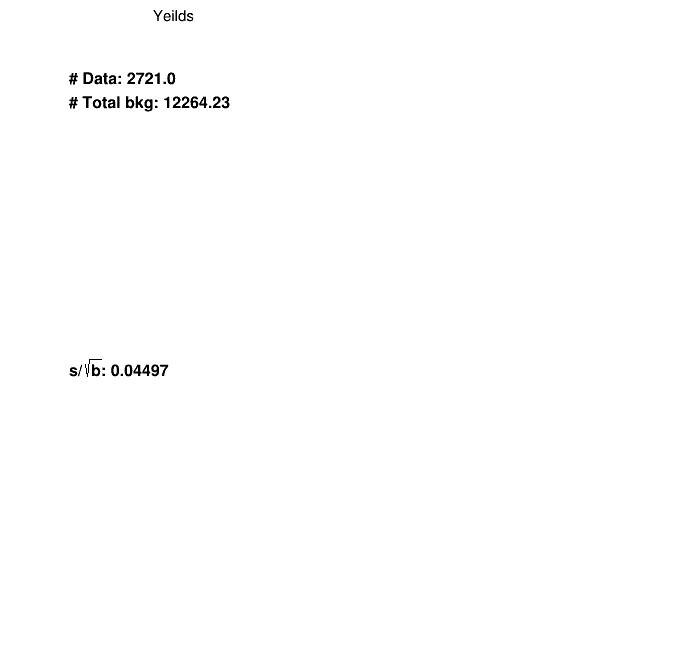

In [27]:
if DRAW_SR:
    region = "SR"

    with Pool() as p:
        p.starmap(wrapper_mp, list_variables) 
#     wrapper_mp('mass_pre', [45, 100, 1000, 'M_{ll} [GeV]'])

    # for pie chart
    hist=HistStack(dic_df_raw, "pt_lead_pre", "weight", 31, 80,  660, "p_{T}(l_{lead}) [GeV]") 
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/preselv1_"+query_str) 
    hist.get_yeilds()
    hist.draw_pie(file_name=DATE+"/Presel/"+ERA+"/"+region+"/pie_"+query_str)

In [28]:
# ###### wotop ######
# dic_variable={
#     "PuppiMET_pre": [14, 100, 660, "Puppi p_{T}^{miss} [GeV]"],    
#     "pt_lead_pre": [15, 80,  660, "p_{T}(l_{lead}) [GeV]"],
#     "pt_trail_pre": [15, 40, 520, "p_{T}(l_{trail}) [GeV]"], 
# }
# os.system("mkdir -p "+DATE+"/Presel/"+ERA+"/"+region+"/wotop")

# for variable, r in dic_variable.items():
#     if not "Puppi" in variable:
#         threshold = 0.3
#     else:
#         threshold = 0.5
#     hist=HistStack(dic_df_raw, variable, "weight", r[0], r[1], r[2], r[3])  
#     c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/normblind_"+query_str, blind_from=threshold)        
#     hist=HistStack(dic_df_raw, variable, "weighthdampUp", r[0], r[1], r[2], r[3])  
#     c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/normblind_hdampUp"+query_str, blind_from=threshold)
#     hist=HistStack(dic_df_raw, variable, "weighthdampDown", r[0], r[1], r[2], r[3])  
#     c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/normblind_hdampDown"+query_str, blind_from=threshold)
#     hist=HistStack(dic_df_raw, variable, "weightPSUp", r[0], r[1], r[2], r[3])  
#     c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/normblind_UEUp"+query_str, blind_from=threshold)
#     hist=HistStack(dic_df_raw, variable, "weightPSDown", r[0], r[1], r[2], r[3])  
#     c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/normblind_UEDown"+query_str, blind_from=threshold)
#     hist=HistStack(dic_df_raw, variable, "wotop", r[0], r[1], r[2], r[3])  
#     c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/wotop/norm_"+query_str, blind_from=threshold) 
# hist.get_yeilds()
# hist.draw_pie(file_name=DATE+"/Presel/"+ERA+"/"+region+"/wotop/pie_"+query_str)  

In [29]:
###### wobsf ######
dic_variable={
    "nbjetflav_pre": [10, 0, 10, "N bjetflav"],     
    "pt_lead_pre": [15, 80,  660, "p_{T}(l_{lead}) [GeV]"],
}
os.system("mkdir -p "+DATE+"/Presel/"+ERA+"/"+region+"/wobsf")

for variable, r in dic_variable.items():
    if not "Puppi" in variable:
        threshold = 0.3
    else:
        threshold = 0.5
    hist=HistStack(dic_df_raw, variable, "weight", r[0], r[1], r[2], r[3])  
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/normblind_"+query_str, blind_from=threshold)        
    hist=HistStack(dic_df_raw, variable, "wobsf", r[0], r[1], r[2], r[3])  
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/wobsf/norm_"+query_str, blind_from=threshold) 

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file 20230526deepCSV_16post/Presel/ee16post/SR/normblind_mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100_nbjetflav_prebreakdown.pdf has been created
Info in <TCanvas::Print>: pdf file 20230526deepCSV_16post/Presel/ee16post/SR/normblind_mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100_nbjetflav_pre.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file 20230526deepCSV_16post/Presel/ee16post/SR/wobsf/norm_mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100_nbjetflav_prebreakdown.pdf has been created
Info in <TCanvas::Print>: pdf file 20230526deepCSV_16post/Presel/ee16post/SR/wobsf/norm_mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100_nbjetflav_pre.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same

# Signal Acc x Eff x presel

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file 20230526deepCSV_16post/Presel/ee16post/SR/sig_eff.pdf has been created


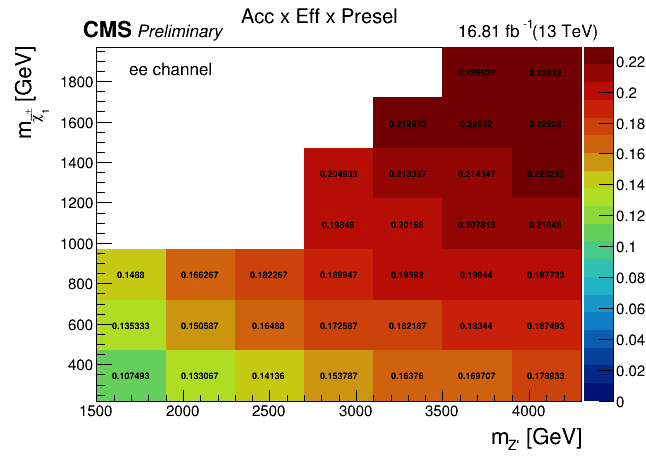

In [30]:
str_channel, str_lumi = HistStack.get_str_lumi_channel(ERA, ERA)

Zp_mass=[1700, 2100, 2500, 2900, 3300, 3700, 4100]
CH_mass=[345, 595, 845, 1095, 1345, 1595, 1845]
c1=rt.TCanvas("c1", "c1", 650, 500)
c1.SetLeftMargin(0.15)
c1.SetBottomMargin(0.15)
h2d1=rt.TH2D("h2d1", "", len(Zp_mass), Zp_mass[0]-200, Zp_mass[-1]+200, len(CH_mass), CH_mass[0]-125, CH_mass[-1]+125)
h2d1.SetTitle("Acc x Eff x Presel")

n_sig_in = 150000/4
if "em" in ERA:
    n_sig_in = 150000/2

for key in dic_df_raw:
    if not "Zp" in key:
        continue
    tmp=key.replace('_', '-')
    tmp=tmp.split('-')
    
    MZp=tmp[1]
    MCH=tmp[3]
    binx=Zp_mass.index(int(MZp))+1
    biny=CH_mass.index(int(MCH))+1
    h2d1.SetBinContent(binx, biny, dic_df_raw[key].shape[0]/(n_sig_in))
# # missing bin by hand
# h2d1.SetBinContent(5, 3, 40000/(n_sig_in)) #mumu: 23500, #ee: 20000
# h2d1.SetBinContent(3, 4, 40000/(n_sig_in)) #mumu: 23500, #ee: 20000

# set_palette("rainbow",255)
rt.gStyle.SetOptStat(0)
rt.gStyle.SetPalette(55)

h2d1.Draw("colz text")
h2d1.SetYTitle("m_{#tilde#chi_{1}^{#pm}} [GeV]")
h2d1.SetXTitle("m_{Z'} [GeV]")
h2d1.GetYaxis().SetTitleSize(0.05)
h2d1.GetXaxis().SetTitleSize(0.05)
latex=rt.TLatex()
latex.DrawLatexNDC( 0.2,0.84, "#scale[0.8]{#font[42]{"+str_channel+" channel}}")

latex1=rt.TLatex()
latex1.DrawLatexNDC(0.71, 0.92, "#font[42]{#scale[0.8]{"+str_lumi+" fb^{-1}(13 TeV)}}");
latex1.DrawLatexNDC(0.13, 0.92, "#font[62]{CMS}#font[42]{#it{#scale[0.8]{ Preliminary}}}");
 
c1.Draw()
c1.SaveAs(DATE+"/Presel/"+ERA+"/"+region+"/sig_eff.pdf")

# MET side band

In [31]:
if RUN_SIDEBAND_MET:
    dic_df_raw={}
    dic_df_met_u_tmp = {}
    dic_df_met_d_tmp = {}
    dic_df_scale_u_tmp = {}
    dic_df_scale_d_tmp = {}
    # query_str="mass_pre<100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100"
    query_str="mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre<100 and PuppiMET_pre>80"
#     query_str="mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre<100 and PuppiMET_pre>80"
    # query_str="mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and MET_pre>80"
    # query_str="mass_pre>60"

    print("####################################################")
    print("####   (unweighted) #events after preselection  ####")
    print("####################################################")
    for key in dic_df:  
        dic_df_raw[key]=dic_df[key].query(query_str)
        dic_df_met_u_tmp[key]=dic_df_met_u[key].query(query_str)
        dic_df_met_d_tmp[key]=dic_df_met_d[key].query(query_str)     
#         dic_df_scale_u_tmp[key]=dic_df_scale_u[key].query(query_str)
#         dic_df_scale_d_tmp[key]=dic_df_scale_d[key].query(query_str) 
        print(key, ":", dic_df_raw[key].shape[0])
    #     print("num of", key, ":", dic_df_jes_u[key].shape[0])
    #     print("num of", key, ":", dic_df_jes_d[key].shape[0])
    nested_dic_df={}
    nested_dic_df["raw"]=dic_df_raw
    nested_dic_df["met_u"]=dic_df_met_u_tmp
    nested_dic_df["met_d"]=dic_df_met_d_tmp    
#     nested_dic_df["scale_u"]=dic_df_scale_u_tmp
#     nested_dic_df["scale_d"]=dic_df_scale_d_tmp
    dic_variable={
        "PuppiMET_pre": [20, 0, 100, "Puppi p_{T}^{miss} [GeV]"],    
#         "MET_pre": [40, 0, 400, "p_{T}^{miss} [GeV]"],    
#         "mass_pre": [30, 100, 700, "M_{ll} [GeV]"],
        "pt_lead_pre": [31, 80,  660, "p_{T}(l_{lead}) [GeV]"],
        "pt_trail_pre": [30, 40, 520, "p_{T}(l_{trail}) [GeV]"],
#         "Zpt_pre": [50, 0, 500, "p_{T}(ll) [GeV]"],
#         "MT_pre": [55, 0, 550, "M_{T} [GeV]"],
#         "MT2_pre": [35, 0, 350, "M_{T2} [GeV]"],
#         "U_pre": [29, 0, 660, "U [GeV]"],
#         "JZB_pre": [29, 80, 660, "JZB"],
#         "dPhill_pre": [17, 0, 3.4, "#Delta#phi(l,l)"],
#         "dPhilMET_pre": [17, 0, 3.4, "#Delta#phi(l,p_{T}^{miss})"],
#         "dRll_pre": [30, 0, 6, "#DeltaR(l,l)"],
#         "dPhillMET_pre": [17, 0, 3.4, "#Delta#phi(ll,p_{T}^{miss})"],
    #     "MC1C1_pre": [36, 180, 900, "MC1C1 [GeV]"], 
    #     "H3PP_pre": [41, 80, 900, "H3PP [GeV]"], 
    #     "H3TPP_pre": [40, 0, 800, "H3TPP [GeV]"], 
#         "eta_lead_pre": [30, -3, 3, "#eta(l_{lead})"],
#         "eta_trail_pre": [30, -3, 3, "#eta(l_{trail})"],
#         "phi_lead_pre": [40, -4, 4, "#phi(l_{lead})"],
#         "phi_trail_pre": [40, -4, 4, "#phi(l_{trail})"], 
#         "PuppiMET_phi_pre": [40, -4, 4, "Puppi p_{T}^{miss} #phi(l_{trail})"],      
    }
    list_variables = [(key, dic_variable[key]) for key in dic_variable]
    
    region = "METSB"
    
    with Pool() as p:
        p.starmap(wrapper_mp, list_variables)    

    # for pie chart
    hist=HistStack(dic_df_raw, "pt_lead_pre", "weight", 31, 80,  660, "p_{T}(l_{lead}) [GeV]") 
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/preselv1_"+query_str) 
    hist.get_yeilds()
    hist.draw_pie(file_name=DATE+"/Presel/"+ERA+"/"+region+"/pie_"+query_str)        

In [32]:
if DUMP_SIDEBAND_MET_PKL:
    with open(DATE+"/Presel/"+ERA+"/"+"nested_dic_df_METSB.pkl", "wb") as f:
        pickle.dump(nested_dic_df, f)

# Mass side band

In [33]:
if RUN_SIDEBAND_MASS and not "em" in ERA:
    dic_df_raw={}
    dic_df_met_u_tmp = {}
    dic_df_met_d_tmp = {}
    dic_df_scale_u_tmp = {}
    dic_df_scale_d_tmp = {}
    # query_str="mass_pre<100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100"
    query_str="mass_pre<100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100"
    # query_str="mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and MET_pre>80"
    # query_str="mass_pre>60"

    print("####################################################")
    print("####   (unweighted) #events after preselection  ####")
    print("####################################################")
    for key in dic_df:  
        dic_df_raw[key]=dic_df[key].query(query_str)
        dic_df_met_u_tmp[key]=dic_df_met_u[key].query(query_str)
        dic_df_met_d_tmp[key]=dic_df_met_d[key].query(query_str)     
#         dic_df_scale_u_tmp[key]=dic_df_scale_u[key].query(query_str)
#         dic_df_scale_d_tmp[key]=dic_df_scale_d[key].query(query_str) 
        print(key, ":", dic_df_raw[key].shape[0])
    #     print("num of", key, ":", dic_df_jes_u[key].shape[0])
    #     print("num of", key, ":", dic_df_jes_d[key].shape[0])
    nested_dic_df={}
    nested_dic_df["raw"]=dic_df_raw
    nested_dic_df["met_u"]=dic_df_met_u_tmp
    nested_dic_df["met_d"]=dic_df_met_d_tmp
#     nested_dic_df["scale_u"]=dic_df_scale_u_tmp
#     nested_dic_df["scale_d"]=dic_df_scale_d_tmp
    
    dic_variable={
        "PuppiMET_pre": [28, 100, 660, "Puppi p_{T}^{miss} [GeV]"],    
        "mass_pre": [1,80, 100, "M_{ll} [GeV]"],
        "pt_lead_pre": [31, 80,  660, "p_{T}(l_{lead}) [GeV]"],
        "pt_trail_pre": [30, 40, 520, "p_{T}(l_{trail}) [GeV]"],
#         "eta_lead_pre": [30, -3, 3, "#eta(l_{lead})"],
#         "eta_trail_pre": [30, -3, 3, "#eta(l_{trail})"],
#         "phi_lead_pre": [40, -4, 4, "#phi(l_{lead})"],
#         "phi_trail_pre": [40, -4, 4, "#phi(l_{trail})"], 
#         "PuppiMET_phi_pre": [40, -4, 4, "Puppi p_{T}^{miss} #phi(l_{trail})"],     
    }

    list_variables = [(key, dic_variable[key]) for key in dic_variable]
    
    region = "MASSSB"
    os.system("mkdir -p "+DATE+"/Presel/"+ERA+"/"+region)
    
    with Pool() as p:
        p.starmap(wrapper_mp, list_variables)    

    # for pie chart
    hist=HistStack(dic_df_raw, "mass_pre", "weight", 1, 80,  100, "M_{ll} [GeV]") 
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/massSB_"+query_str) 
    hist.get_yeilds()
    hist.create_root_file(file_name=DATE+"/Presel/"+ERA+"/"+region+"/shape_v1_massSB")
    hist.export_hist("Zp-2500_CH-345", file_name=DATE+"/Presel/"+ERA+"/"+region+"/shape_v1_massSB") 
    hist.draw_pie(file_name=DATE+"/Presel/"+ERA+"/"+region+"/pie_"+query_str)
    
    sys_list = ["puweight", "l1prefiring", "effSF", "topSF", "trigSF"] 
#     sys_list = ["puweight", "l1prefiring", "effSF", "topSF"] 
    for s in sys_list:
        hist=HistStack(dic_df_raw, "mass_pre", 'weight'+s+'Up', 1, 80,  100, "M_{ll} [GeV]")
        c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/massSB_"+query_str) 
        hist.export_hist("Zp-2500_CH-345", file_name=DATE+"/Presel/"+ERA+"/"+region+"/shape_v1_massSB")
        hist=HistStack(dic_df_raw, "mass_pre", 'weight'+s+'Down', 1, 80,  100, "M_{ll} [GeV]")
        c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/massSB_"+query_str) 
        hist.export_hist("Zp-2500_CH-345", file_name=DATE+"/Presel/"+ERA+"/"+region+"/shape_v1_massSB")
    hist=HistStack(dic_df_met_u_tmp, "mass_pre", 'weightmetUp', 1, 80,  100, "M_{ll} [GeV]")
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/massSB_"+query_str) 
    hist.export_hist("Zp-2500_CH-345", file_name=DATE+"/Presel/"+ERA+"/"+region+"/shape_v1_massSB") 
    hist=HistStack(dic_df_met_d_tmp, "mass_pre", 'weightmetDown', 1, 80,  100, "M_{ll} [GeV]")
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/massSB_"+query_str) 
    hist.export_hist("Zp-2500_CH-345", file_name=DATE+"/Presel/"+ERA+"/"+region+"/shape_v1_massSB")      

In [34]:
if DUMP_SIDEBAND_MASS_PKL and not "em" in ERA:
    with open(DATE+"/Presel/"+ERA+"/"+"nested_dic_df_MASS.pkl", "wb") as f:
        pickle.dump(nested_dic_df, f)

# PT side band

In [35]:
if RUN_SIDEBAND_PT:
    dic_df_raw={}
    dic_df_met_u_tmp = {}
    dic_df_met_d_tmp = {}
    dic_df_scale_u_tmp = {}
    dic_df_scale_d_tmp = {}
    # query_str="mass_pre<100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100"
    query_str="mass_pre>100 and pt_lead_pre>80 and pt_trail_pre<40 and PuppiMET_pre>100"
#     query_str="mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre<100 and PuppiMET_pre>80"
    # query_str="mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and MET_pre>80"
    # query_str="mass_pre>60"

    print("####################################################")
    print("####   (unweighted) #events after preselection  ####")
    print("####################################################")
    for key in dic_df:  
        dic_df_raw[key]=dic_df[key].query(query_str)
        dic_df_met_u_tmp[key]=dic_df_met_u[key].query(query_str)
        dic_df_met_d_tmp[key]=dic_df_met_d[key].query(query_str)     
#         dic_df_scale_u_tmp[key]=dic_df_scale_u[key].query(query_str)
#         dic_df_scale_d_tmp[key]=dic_df_scale_d[key].query(query_str) 
        print(key, ":", dic_df_raw[key].shape[0])
    #     print("num of", key, ":", dic_df_jes_u[key].shape[0])
    #     print("num of", key, ":", dic_df_jes_d[key].shape[0])
    nested_dic_df={}
    nested_dic_df["raw"]=dic_df_raw
    nested_dic_df["met_u"]=dic_df_met_u_tmp
    nested_dic_df["met_d"]=dic_df_met_d_tmp    
#     nested_dic_df["scale_u"]=dic_df_scale_u_tmp
#     nested_dic_df["scale_d"]=dic_df_scale_d_tmp
    dic_variable={
        "PuppiMET_pre": [14, 100, 660, "Puppi p_{T}^{miss} [GeV]"],    
#         "MET_pre": [40, 0, 400, "p_{T}^{miss} [GeV]"],    
        "mass_pre": [22, 100, 1000, "M_{ll} [GeV]"],
        "pt_lead_pre": [15, 80,  660, "p_{T}(l_{lead}) [GeV]"],
        "pt_trail_pre": [4, 0, 40, "p_{T}(l_{trail}) [GeV]"],
#         "Zpt_pre": [25, 0, 500, "p_{T}(ll) [GeV]"],
#         "MT_pre": [27, 0, 550, "M_{T} [GeV]"],
#         "MT2_pre": [17, 0, 350, "M_{T2} [GeV]"],
#         "U_pre": [14, 0, 660, "U [GeV]"],
#         "JZB_pre": [14, 80, 660, "JZB"],
#         "dPhill_pre": [17, 0, 3.4, "#Delta#phi(l,l)"],
#         "dPhilMET_pre": [17, 0, 3.4, "#Delta#phi(l,p_{T}^{miss})"],
#         "dRll_pre": [30, 0, 6, "#DeltaR(l,l)"],
#         "dPhillMET_pre": [17, 0, 3.4, "#Delta#phi(ll,p_{T}^{miss})"],
#     #     "MC1C1_pre": [36, 180, 900, "MC1C1 [GeV]"], 
#     #     "H3PP_pre": [41, 80, 900, "H3PP [GeV]"], 
#     #     "H3TPP_pre": [40, 0, 800, "H3TPP [GeV]"], 
#         "eta_lead_pre": [15, -3, 3, "#eta(l_{lead})"],
#         "eta_trail_pre": [15, -3, 3, "#eta(l_{trail})"],
# #         "phi_lead_pre": [40, -4, 4, "#phi(l_{lead})"],
# #         "phi_trail_pre": [40, -4, 4, "#phi(l_{trail})"], 
#         "PuppiMET_phi_pre": [20, -4, 4, "Puppi p_{T}^{miss} #phi(l_{trail})"],      
    }
    list_variables = [(key, dic_variable[key]) for key in dic_variable]
    
    region = "PTSB"
    os.system("mkdir -p "+DATE+"/Presel/"+ERA+"/"+region)
    
    sys_list = ["puweight", "l1prefiring", "effSF", "topSF", "trigSF", "hdamp", "PS"]
    
    with Pool() as p:
        p.starmap(wrapper_mp, list_variables)    

    # for pie chart
    hist=HistStack(dic_df_raw, "pt_lead_pre", "weight", 31, 80,  660, "p_{T}(l_{lead}) [GeV]") 
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/preselv1_"+query_str) 
    hist.get_yeilds()
    hist.draw_pie(file_name=DATE+"/Presel/"+ERA+"/"+region+"/pie_"+query_str)        

In [36]:
if DUMP_SIDEBAND_PT_PKL:
    with open(DATE+"/Presel/"+ERA+"/"+"nested_dic_df_PT.pkl", "wb") as f:
        pickle.dump(nested_dic_df, f)

# b tag selection

In [37]:
if RUN_BTAG:
    dic_variable={
#         "MET_pre": [25, 0, 500, "p_{T}^{miss} [GeV]"],    
#         "PuppiMET_pre": [50, 0, 500, "Puppi p_{T}^{miss} [GeV]"],    
#         "mass_pre": [30, 100, 700, "M_{ll} [GeV]"],
        "pt_lead_pre": [31, 80,  660, "p_{T}(l_{lead}) [GeV]"],
        "pt_trail_pre": [30, 40, 520, "p_{T}(l_{trail}) [GeV]"],
#         "Zpt_pre": [50, 0, 500, "p_{T}(ll) [GeV]"],
#         "MT_pre": [55, 0, 550, "M_{T} [GeV]"],
#         "MT2_pre": [35, 0, 350, "M_{T2} [GeV]"],
#         "U_pre": [29, 0, 660, "U [GeV]"],
#         "JZB_pre": [29, 80, 660, "JZB"],
#         "dPhill_pre": [17, 0, 3.4, "#Delta#phi(l,l)"],
#         "dPhilMET_pre": [17, 0, 3.4, "#Delta#phi(l,p_{T}^{miss})"],
#         "dRll_pre": [30, 0, 6, "#DeltaR(l,l)"],
#         "dPhillMET_pre": [17, 0, 3.4, "#Delta#phi(ll,p_{T}^{miss})"],
#         "eta_lead_pre": [30, -3, 3, "#eta(l_{lead})"],
#         "eta_trail_pre": [30, -3, 3, "#eta(l_{trail})"],
#         "phi_lead_pre": [40, -4, 4, "#phi(l_{lead})"],
#         "phi_trail_pre": [40, -4, 4, "#phi(l_{trail})"], 
#         "PuppiMET_phi_pre": [40, -4, 4, "Puppi p_{T}^{miss} #phi(l_{trail})"], 
        "nbjetflav_pre": [10, 0, 10, "N bjetflav"], 
#         "nbjet_pre": [10, 0, 10, "N bjet"], 
        "njet_pre": [10, 0, 10, "N jet"], 
#         "njet_l_pre": [9, 1, 10, "N  l jet"],     
#         "njet_c_pre": [9, 1, 10, "N  c jet"],     
#         "njet_b_pre": [9, 1, 10, "N  b jet"],    
#         "btagSF0_pre": [40, 0.9, 1.3, "B SF"],    
    }
    
#     base_line = "mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>80 and PuppiMET_pre>150 and MT_pre>130"
    base_line = "mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100"
#     query_str="mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100 and njet_pre==1" #temp!
    query_str=base_line+" and nbjetflav_pre==0" #temp!
#     query_str=base_line #temp!

    dic_df_raw={}
    dic_df_met_u_tmp = {}
    dic_df_met_d_tmp = {}
    dic_df_met_ue_u_tmp = {}
    dic_df_met_ue_d_tmp = {}    
    
    print("####################################################")
    print("####   (unweighted) #events after preselection  ####")
    print("####################################################")
    for key in dic_df:  
        dic_df_raw[key]=dic_df[key].query(query_str)
        dic_df_met_u_tmp[key]=dic_df_met_u[key].query(query_str)
        dic_df_met_d_tmp[key]=dic_df_met_d[key].query(query_str)
        dic_df_met_ue_u_tmp[key]=dic_df_met_ue_u[key].query(query_str) # probably pt cut incorrect
        dic_df_met_ue_d_tmp[key]=dic_df_met_ue_d[key].query(query_str)        
        print(key, ":", dic_df_raw[key].shape[0])

    nested_dic_df={}
    nested_dic_df["raw"]=dic_df_raw
    nested_dic_df["met_u"]=dic_df_met_u_tmp
    nested_dic_df["met_d"]=dic_df_met_d_tmp
    nested_dic_df["met_ue_u"]=dic_df_met_ue_u_tmp
    nested_dic_df["met_ue_d"]=dic_df_met_ue_d_tmp
        
    list_variables = [(key, dic_variable[key]) for key in dic_variable]
    
    region = "SR1"
    os.system("mkdir -p "+DATE+"/Presel/"+ERA+"/"+region)
    
    sys_list = ["puweight", "l1prefiring", "effSF", "topSF", "met", "metue", "trigSF", "hdamp", "PS", "btagSF"]
    
    with Pool() as p:
        p.starmap(wrapper_mp, list_variables)    

    # for pie chart
    hist=HistStack(dic_df_raw, "pt_lead_pre", "weight", 31, 80,  660, "p_{T}(l_{lead}) [GeV]") 
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/preselv1_"+query_str) 
    hist.get_yeilds()
    hist.draw_pie(file_name=DATE+"/Presel/"+ERA+"/"+region+"/pie_"+query_str) 

    with open(DATE+"/Presel/"+ERA+"/"+"nested_dic_df_SR1.pkl", "wb") as f:
        pickle.dump(nested_dic_df, f)     
    
    ###############
    query_str=base_line+" and nbjetflav_pre>0" #temp!
#     query_str=base_line #temp!

    dic_df_raw={}
    dic_df_met_u_tmp = {}
    dic_df_met_d_tmp = {}
    dic_df_met_ue_u_tmp = {}
    dic_df_met_ue_d_tmp = {}    
    
    print("####################################################")
    print("####   (unweighted) #events after preselection  ####")
    print("####################################################")
    for key in dic_df:  
        dic_df_raw[key]=dic_df[key].query(query_str)
        dic_df_met_u_tmp[key]=dic_df_met_u[key].query(query_str)
        dic_df_met_d_tmp[key]=dic_df_met_d[key].query(query_str)
        dic_df_met_ue_u_tmp[key]=dic_df_met_ue_u[key].query(query_str) # probably pt cut incorrect
        dic_df_met_ue_d_tmp[key]=dic_df_met_ue_d[key].query(query_str)        
        print(key, ":", dic_df_raw[key].shape[0])

    nested_dic_df={}
    nested_dic_df["raw"]=dic_df_raw
    nested_dic_df["met_u"]=dic_df_met_u_tmp
    nested_dic_df["met_d"]=dic_df_met_d_tmp
    nested_dic_df["met_ue_u"]=dic_df_met_ue_u_tmp
    nested_dic_df["met_ue_d"]=dic_df_met_ue_d_tmp
        
    list_variables = [(key, dic_variable[key]) for key in dic_variable]
    
    region = "TTCR"
    os.system("mkdir -p "+DATE+"/Presel/"+ERA+"/"+region)
    
    sys_list = ["puweight", "l1prefiring", "effSF", "topSF", "met", "metue", "trigSF", "hdamp", "PS", "btagSF"]
    
    with Pool() as p:
        p.starmap(wrapper_mp, list_variables)    

    # for pie chart
    hist=HistStack(dic_df_raw, "pt_lead_pre", "weight", 31, 80,  660, "p_{T}(l_{lead}) [GeV]") 
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/preselv1_"+query_str) 
    hist.get_yeilds()
    hist.draw_pie(file_name=DATE+"/Presel/"+ERA+"/"+region+"/pie_"+query_str)  
    
    with open(DATE+"/Presel/"+ERA+"/"+"nested_dic_df_TTCR.pkl", "wb") as f:
        pickle.dump(nested_dic_df, f)    

####################################################
####   (unweighted) #events after preselection  ####
####################################################
DY1000To1500 : 617
DY1500To2000 : 874
DY2000To3000 : 1120
DY500To700 : 105
DY700To800 : 0
DY800To1000 : 0
DY : 63
HWW : 0
H : 0
TTDown : 7914
TTSemi : 17
TTUp : 7882
TTZ : 1454
TT : 18968
TThdampDown : 7772
TThdampUp : 8345
WWW : 8970
WWZ : 2694
WW : 1836
WZQQ : 79
WZ : 3898
ZZ : 7670
Zp-1700_CH-345 : 3918
Zp-1700_CH-595 : 4933
Zp-1700_CH-845 : 5428
Zp-2100_CH-345 : 4828
Zp-2100_CH-595 : 5464
Zp-2100_CH-845 : 6063
Zp-2500_CH-345 : 5120
Zp-2500_CH-595 : 5996
Zp-2500_CH-845 : 6641
Zp-2900_CH-1095 : 7224
Zp-2900_CH-1345 : 7483
Zp-2900_CH-345 : 5570
Zp-2900_CH-595 : 6274
Zp-2900_CH-845 : 6903
Zp-3300_CH-1095 : 7326
Zp-3300_CH-1345 : 7710
Zp-3300_CH-1595 : 7944
Zp-3300_CH-345 : 5914
Zp-3300_CH-595 : 6600
Zp-3300_CH-845 : 7118
Zp-3700_CH-1095 : 7534
Zp-3700_CH-1345 : 7781
Zp-3700_CH-1595 : 8014
Zp-3700_CH-1845 : 8142
Zp-3700_CH-345 : 6

Process ForkPoolWorker-50:
Process ForkPoolWorker-53:
Process ForkPoolWorker-43:
Process ForkPoolWorker-51:
Process ForkPoolWorker-42:
Process ForkPoolWorker-47:
Process ForkPoolWorker-49:
Process ForkPoolWorker-46:
Process ForkPoolWorker-54:
Process ForkPoolWorker-45:
Process ForkPoolWorker-55:
Process ForkPoolWorker-56:
Process ForkPoolWorker-44:
Process ForkPoolWorker-48:
Process ForkPoolWorker-52:


KeyboardInterrupt: 

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file 20230526deepCSV_16post/Presel/ee16post/SR1/sys/norm_mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100 and nbjetflav_pre==0_pt_trail_prebreakdown.pdf has been created
Info in <TCanvas::Print>: pdf file 20230526deepCSV_16post/Presel/ee16post/SR1/sys/norm_mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100 and nbjetflav_pre==0_pt_lead_prebreakdown.pdf has been created
Info in <TCanvas::Print>: pdf file 20230526deepCSV_16post/Presel/ee16post/SR1/sys/norm_mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100 and nbjetflav_pre==0_njet_prebreakdown.pdf has been created
Info in <TCanvas::Print>: pdf file 20230526deepCSV_16

# Export variables

In [ ]:
if EXPORT_VARIABLE:
    # draw
    # get plot configuration
    dic_variable={
    #     "pt_trail_pre": [8, 40, 300, "p_{T}(l_{trail}) [GeV]"],
    #     "MT2_pre": [8, 0, 160, "M_{T2} [GeV]"],
        "H3PP_pre": [19, 95, 900, "H3PP [GeV]"],     
    }
    sys_src={
        "presel":["effSF_pre", "l1prefiring_pre", "puweight_pre"]
    #     "presel":["effSF_pre", "l1prefiring_pre", "puweight_pre", "topSF_pre"]
    }
    # sys_src=[]
    for key in dic_df_raw:
        if "Zp" in key:
            for variable, r in dic_variable.items():
                hist=HistStack(dic_df_raw, variable, sys_src, "presel", r[0], r[1], r[2], r[3])            
                c1=hist.draw_hist(key, ERA, ERA+"_exportdev"+query_str, True) 
                hist.create_root_file(key, variable, channel)
                hist.export_hist(key, variable, channel, "") 

    #simply from last instance
    print(hist.get_yeilds())
    hist.draw_pie()
    print(hist.nbin)
